test and work with lstm model of https://doi.org/10.1109/CIFEr52523.2022.9776141

2 lstm with wavelets

#lookback = 1, wavelet = db1, level = 1

In [ ]:
!pip install yfinance

In [ ]:
! pip install --upgrade yfinance


In [ ]:
import time, requests
import numpy as np
import pandas as pd
import pywt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import yfinance as yf
from pandas_datareader import data as pdr

def fetch_gc(symbol, start, end):

    # 1) yfinance.download
    try:
        df = yf.download(
            tickers=symbol,
            start=start,
            end=end,
            auto_adjust=True,
            threads=False
        )[["Close"]]
        if not df.empty:
            print("Fetched with yf.download:", df.shape)
            print(df.head())
            return df.dropna()
    except Exception as e:
        print("download() failed:", e)


    try:
        df = yf.Ticker(symbol).history(
            start=start,
            end=end,
            interval="1d",
            auto_adjust=True
        )[["Close"]]
        if not df.empty:
            print("Fetched with Ticker.history:", df.shape)
            print(df.head())
            return df.dropna()
    except Exception as e:
        print("Ticker.history() failed:", e)

    #pandas_datareader
    try:
        df = pdr.get_data_yahoo(symbol, start=start, end=end)[["Close"]]
        if not df.empty:
            print("Fetched with pandas_datareader:", df.shape)
            print(df.head())
            return df.dropna()
    except Exception as e:
        print("pdr.get_data_yahoo() failed:", e)

    #direct CSV download
    try:
        period1 = int(time.mktime(pd.to_datetime(start).timetuple()))
        period2 = int(time.mktime(pd.to_datetime(end).timetuple()))
        url = (
            f"https://query1.finance.yahoo.com/v7/finance/download/{symbol}"
            f"?period1={period1}&period2={period2}"
            "&interval=1d&events=history"
        )
        r = requests.get(url)
        r.raise_for_status()
        df = pd.read_csv(
            pd.compat.StringIO(r.text),
            parse_dates=["Date"], index_col="Date"
        )[["Close"]]
        if not df.empty:
            print("Fetched with direct CSV URL:", df.shape)
            print(df.head())
            return df.dropna()
    except Exception as e:
        print("CSV-download failed:", e)

    raise RuntimeError(f"All fetch methods failed for {symbol}")

# ──────────────────────────────────────────────────────────────────────────────

start_date = "2020-01-01"
end_date   = pd.Timestamp.today().strftime("%Y-%m-%d")
df = fetch_gc("GC=F", start_date, end_date)

# Split
train_val_df = df.loc[:'2025-01-01']
test_df      = df.loc['2025-01-02':]

val_size   = int(0.15 * len(train_val_df))
train_df   = train_val_df.iloc[:-val_size]
val_df     = train_val_df.iloc[-val_size:]
print(f"Rows → Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Scale
scaler        = MinMaxScaler((0,1))
train_scaled = scaler.fit_transform(train_df[['Close']])
val_scaled   = scaler.transform(val_df[['Close']])
test_scaled  = scaler.transform(test_df[['Close']])



# Trim to even length for SWT
def trim_for_swt(arr, df_ref, div):
    """Trim the last few samples so len(arr) % div == 0."""
    rem = arr.shape[0] % div
    if rem > 0:  # Only trim if needed
        arr = arr[:-rem]
        df_ref.drop(df_ref.tail(rem).index, inplace=True)
    return arr, df_ref
##########################################################3
wavelet = 'db1'
level   = 1
div = 2**level

train_scaled, train_df = trim_for_swt(train_scaled, train_df, div)
val_scaled,   val_df   = trim_for_swt(val_scaled,   val_df, div)
test_scaled,  test_df  = trim_for_swt(test_scaled,  test_df, div)
print("Trimmed lengths →",
      len(train_scaled), len(val_scaled), len(test_scaled))



# SWT level-1
coeffs_train = pywt.swt(train_scaled[:,0], wavelet, level=level)
coeffs_val   = pywt.swt(val_scaled[:,0],   wavelet, level=level)
coeffs_test  = pywt.swt(test_scaled[:,0],  wavelet, level=level)

cA_train = coeffs_train[-1][0]
cA_val   = coeffs_val[-1][0]
cA_test  = coeffs_test[-1][0]

cD_train = coeffs_train[0][1]
cD_val   = coeffs_val[0][1]
cD_test  = coeffs_test[0][1]

###########################################################3
def make_sequences(data, look_back=1):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

look_back = 1
X_A_train, y_A_train = make_sequences(cA_train.reshape(-1,1), look_back)
X_A_val,   y_A_val   = make_sequences(cA_val.reshape(-1,1),   look_back)
X_A_test,  y_A_test  = make_sequences(cA_test.reshape(-1,1),  look_back)

X_D_train, y_D_train = make_sequences(cD_train.reshape(-1,1), look_back)
X_D_val,   y_D_val   = make_sequences(cD_val.reshape(-1,1),   look_back)
X_D_test,  y_D_test  = make_sequences(cD_test.reshape(-1,1),  look_back)

# Reshape for LSTM
def to_lstm_shape(X):
    return X.reshape(-1, look_back, 1)

X_A_train, X_A_val, X_A_test = map(to_lstm_shape, (X_A_train, X_A_val, X_A_test))
X_D_train, X_D_val, X_D_test = map(to_lstm_shape, (X_D_train, X_D_val, X_D_test))

# Build model
def build_lstm():
    model = Sequential([
        LSTM(100, input_shape=(look_back, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_absolute_percentage_error')
    return model

model_A = build_lstm()
model_D = build_lstm()

# Train
model_A.fit(X_A_train, y_A_train,
            epochs=150, batch_size=100,
            shuffle=False,
            validation_data=(X_A_val, y_A_val),
            verbose=2)

model_D.fit(X_D_train, y_D_train,
            epochs=150, batch_size=100,
            shuffle=False,
            validation_data=(X_D_val, y_D_val),
            verbose=2)

# Predict + invert scale
pred_A       = model_A.predict(X_A_test).flatten()
pred_D       = model_D.predict(X_D_test).flatten()
combo_scaled = pred_A + pred_D

combo_prices = scaler.inverse_transform(combo_scaled.reshape(-1,1))
true_prices  = scaler.inverse_transform(y_A_test.reshape(-1,1))

[*********************100%***********************]  1 of 1 completed

Fetched with yf.download: (1473, 1)
Price             Close
Ticker             GC=F
Date                   
2020-01-02  1524.500000
2020-01-03  1549.199951
2020-01-06  1566.199951
2020-01-07  1571.800049
2020-01-08  1557.400024
Rows → Train: 1070, Val: 188, Test: 215
Trimmed lengths → 1070 188 214
Epoch 1/150



/tmp/ipython-input-3671127586.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ref.drop(df_ref.tail(rem).index, inplace=True)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 2s - 206ms/step - loss: 96.6322 - val_loss: 93.9787
Epoch 2/150
11/11 - 0s - 13ms/step - loss: 89.8618 - val_loss: 87.6588
Epoch 3/150
11/11 - 0s - 12ms/step - loss: 83.3960 - val_loss: 80.9637
Epoch 4/150
11/11 - 0s - 12ms/step - loss: 76.5586 - val_loss: 73.5175
Epoch 5/150
11/11 - 0s - 14ms/step - loss: 68.8810 - val_loss: 64.9695
Epoch 6/150
11/11 - 0s - 12ms/step - loss: 60.2527 - val_loss: 55.1662
Epoch 7/150
11/11 - 0s - 12ms/step - loss: 51.5406 - val_loss: 44.6447
Epoch 8/150
11/11 - 0s - 12ms/step - loss: 43.0241 - val_loss: 33.3690
Epoch 9/150
11/11 - 0s - 27ms/step - loss: 34.5692 - val_loss: 21.5114
Epoch 10/150
11/11 - 0s - 12ms/step - loss: 28.1840 - val_loss: 11.4102
Epoch 11/150
11/11 - 0s - 13ms/step - loss: 26.5940 - val_loss: 7.3702
Epoch 12/150
11/11 - 0s - 13ms/step - loss: 24.5812 - val_loss: 6.2095
Epoch 13/150
11/11 - 0s - 13ms/step - loss: 21.2847 - val_loss: 3.3207
Epoch 14/150
11/11 - 0s - 14ms/step - loss: 18.3842 - val_loss: 1.6953
Epoch 15/150
11/

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Test MAPE: 2.69%


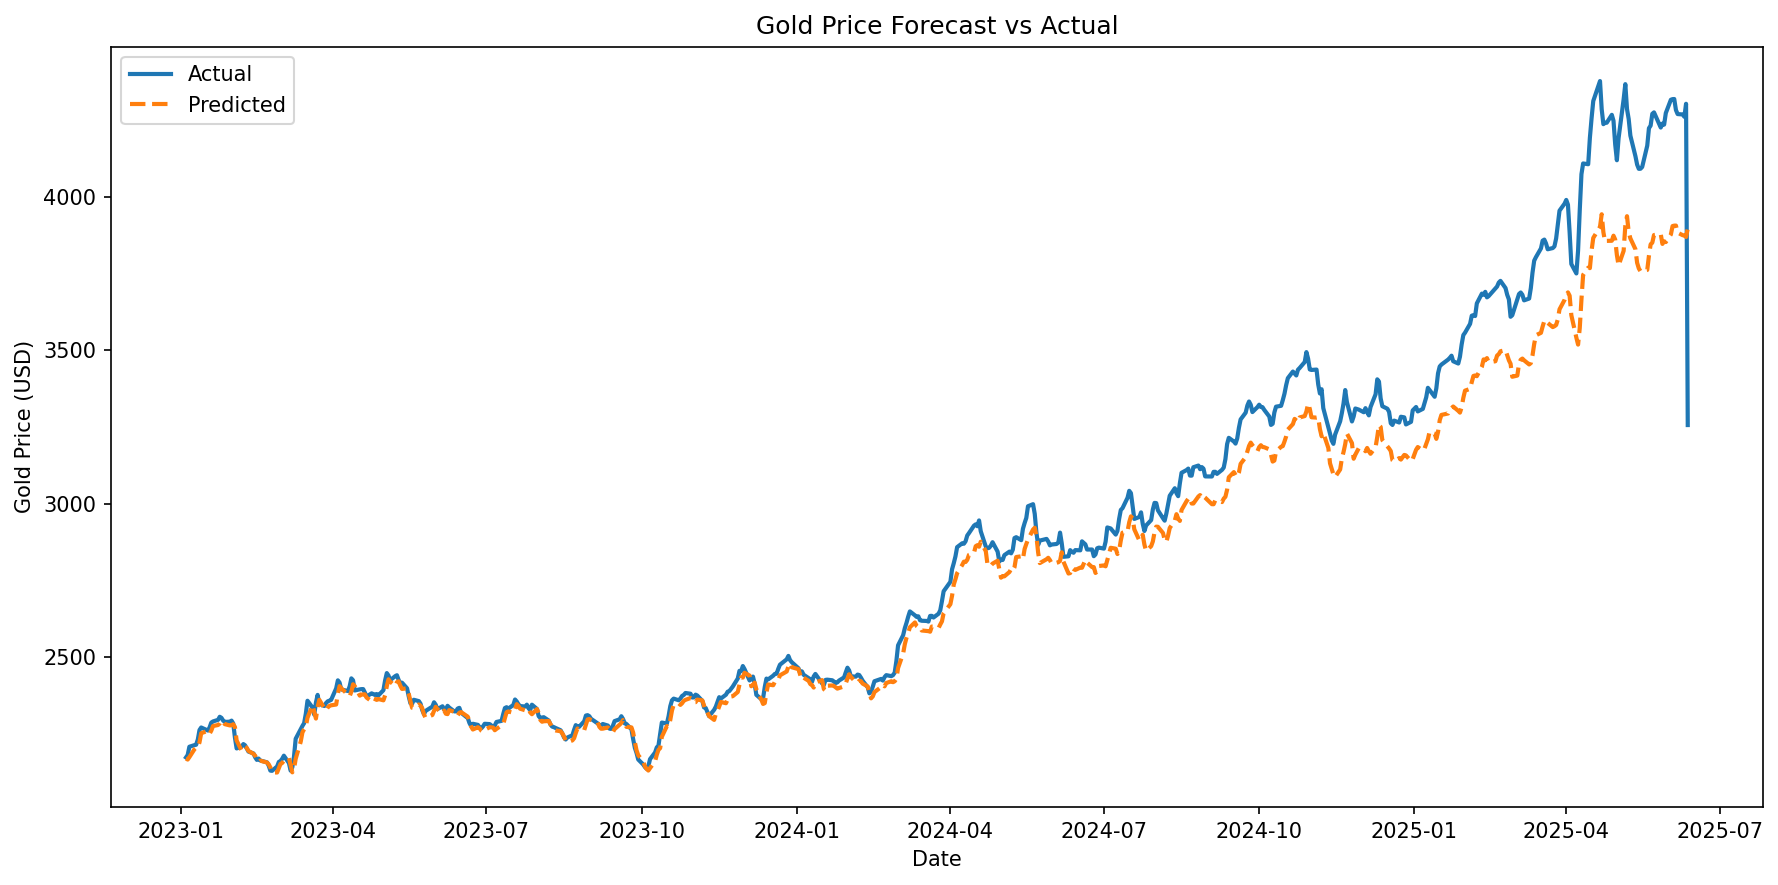

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error


y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
dates = test_df.index[look_back:]
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
print(f"Test MAPE: {mape:.2f}%")

plt.figure(figsize=(12,6), dpi=150)
plt.plot(dates, y_true, label='Actual', linewidth=2)
plt.plot(dates, y_pred, label='Predicted', linestyle='--', linewidth=2)
plt.title("Gold Price Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np


y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
r2   = r2_score(y_true, y_pred)


n   = len(y_true)
sse = np.sum((y_true - y_pred)**2)
rse = np.sqrt(sse / (n - 1 - 1))
print(f"RMSE: {rmse:.2f} USD")
print(f"MAE:  {mae:.2f} USD")
print(f"MAPE: {mape:.2f}%")
print(f"RSE:  {rse:.2f} USD")
print(f"R²:   {r2:.4f}")


RMSE: 143.19 USD
MAE:  92.10 USD
MAPE: 2.69%
RSE:  143.42 USD
R²:   0.9452


new dates

Test MAPE: 13.85%


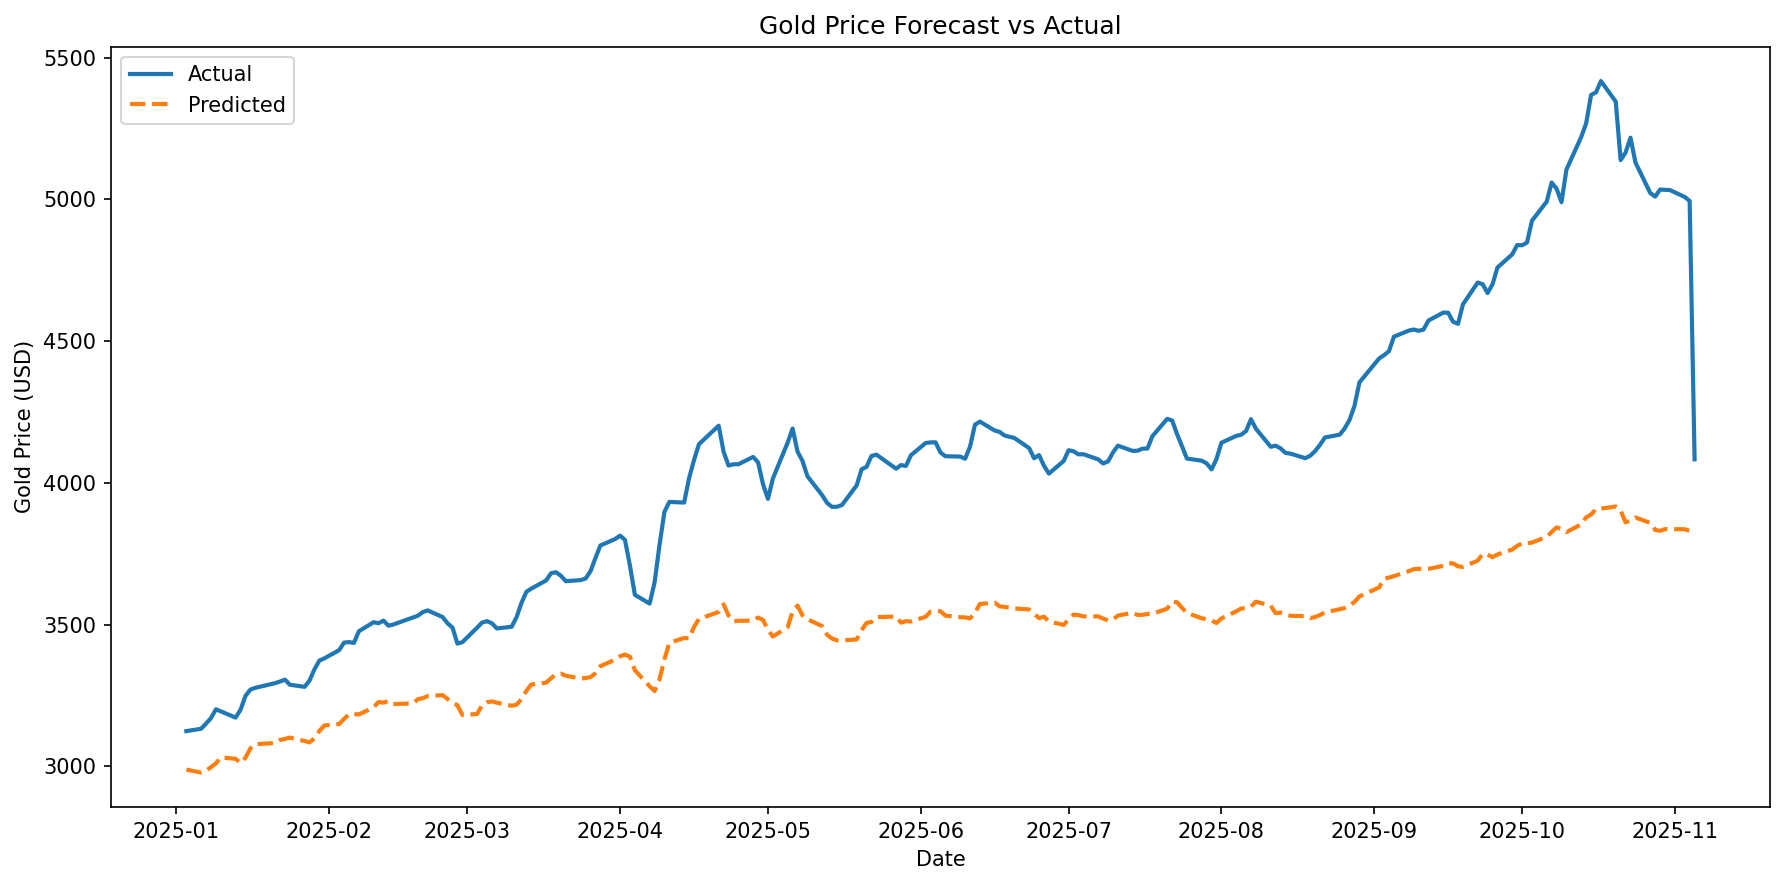

RMSE: 669.45 USD
MAE:  592.49 USD
MAPE: 13.85%
RSE:  672.61 USD
R²:   -0.5963


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np

y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
dates = test_df.index[look_back:]
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
print(f"Test MAPE: {mape:.2f}%")

plt.figure(figsize=(12,6), dpi=150)
plt.plot(dates, y_true, label='Actual', linewidth=2)
plt.plot(dates, y_pred, label='Predicted', linestyle='--', linewidth=2)
plt.title("Gold Price Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()




rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
r2   = r2_score(y_true, y_pred)
n   = len(y_true)
sse = np.sum((y_true - y_pred)**2)
rse = np.sqrt(sse / (n - 1 - 1))

print(f"RMSE: {rmse:.2f} USD")
print(f"MAE:  {mae:.2f} USD")
print(f"MAPE: {mape:.2f}%")
print(f"RSE:  {rse:.2f} USD")
print(f"R²:   {r2:.4f}")


#lookback = 10, wavelet = db1, level = 1

In [ ]:
import numpy as np
import pandas as pd
import pywt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


import yfinance as yf
start_date = "2010-01-01"
end_date   = pd.Timestamp.today().strftime("%Y-%m-%d")
df = yf.download("GC=F", start=start_date, end=end_date)[["Close"]].dropna()


train_val_df = df.loc[:'2023-01-01']
test_df      = df.loc['2023-01-02':]


val_size   = int(0.15 * len(train_val_df))
train_df   = train_val_df.iloc[:-val_size]
val_df     = train_val_df.iloc[-val_size:]

print(f"Rows → Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

scaler      = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train_df[['Close']])
val_scaled   = scaler.transform(val_df[['Close']])
test_scaled  = scaler.transform(test_df[['Close']])

#If lengths are odd, trim last row for SWT
if train_scaled.shape[0] % 2 != 0:
    train_scaled = train_scaled[:-1]
    train_df = train_df.iloc[:-1]
if val_scaled.shape[0] % 2 != 0:
    val_scaled = val_scaled[:-1]
    val_df = val_df.iloc[:-1]
if test_scaled.shape[0] % 2 != 0:
    test_scaled = test_scaled[:-1]
    test_df = test_df.iloc[:-1]



cA_train, cD_train = pywt.swt(train_scaled[:,0], 'db1', level=1)[0]
cA_val,   cD_val   = pywt.swt(val_scaled[:,0],   'db1', level=1)[0]
cA_test,  cD_test  = pywt.swt(test_scaled[:,0],  'db1', level=1)[0]


def make_sequences(data, look_back=10):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

look_back = 10
X_A_train, y_A_train = make_sequences(cA_train.reshape(-1,1), look_back)
X_A_val,   y_A_val   = make_sequences(cA_val.reshape(-1,1),   look_back)
X_A_test,  y_A_test  = make_sequences(cA_test.reshape(-1,1),  look_back)

X_D_train, y_D_train = make_sequences(cD_train.reshape(-1,1), look_back)
X_D_val,   y_D_val   = make_sequences(cD_val.reshape(-1,1),   look_back)
X_D_test,  y_D_test  = make_sequences(cD_test.reshape(-1,1),  look_back)


X_A_train = X_A_train.reshape(-1, look_back, 1)
X_A_val   = X_A_val.reshape(-1, look_back, 1)
X_A_test  = X_A_test.reshape(-1, look_back, 1)
X_D_train = X_D_train.reshape(-1, look_back, 1)
X_D_val   = X_D_val.reshape(-1, look_back, 1)
X_D_test  = X_D_test.reshape(-1, look_back, 1)


def build_lstm_model():
    m = Sequential([
        LSTM(100, input_shape=(look_back, 1)),
        Dense(1)
    ])
    m.compile(optimizer='adam', loss='mean_absolute_percentage_error')
    return m

model_A = build_lstm_model()
model_D = build_lstm_model()


history_A = model_A.fit(
    X_A_train, y_A_train,
    epochs=150, batch_size=100,
    shuffle=False,
    validation_data=(X_A_val, y_A_val),
    verbose=2
)
history_D = model_D.fit(
    X_D_train, y_D_train,
    epochs=150, batch_size=100,
    shuffle=False,
    validation_data=(X_D_val, y_D_val),
    verbose=2
)


pred_A = model_A.predict(X_A_test).flatten()
pred_D = model_D.predict(X_D_test).flatten()
combo_scaled = pred_A + pred_D
combo_prices = scaler.inverse_transform(combo_scaled.reshape(-1,1))
true_prices  = scaler.inverse_transform(y_A_test.reshape(-1,1))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Rows → Train: 2779, Val: 490, Test: 615
Epoch 1/150
28/28 - 4s - 134ms/step - loss: 41.3515 - val_loss: 5.1815
Epoch 2/150
28/28 - 1s - 18ms/step - loss: 12.5171 - val_loss: 3.0300
Epoch 3/150
28/28 - 1s - 25ms/step - loss: 11.9855 - val_loss: 7.5195
Epoch 4/150
28/28 - 1s - 19ms/step - loss: 8.4297 - val_loss: 2.9934
Epoch 5/150
28/28 - 1s - 18ms/step - loss: 8.3018 - val_loss: 3.0302
Epoch 6/150
28/28 - 1s - 21ms/step - loss: 8.3495 - val_loss: 3.7096
Epoch 7/150
28/28 - 1s - 22ms/step - loss: 8.0430 - val_loss: 2.7678
Epoch 8/150
28/28 - 1s - 20ms/step - loss: 7.7738 - val_loss: 2.8433
Epoch 9/150
28/28 - 1s - 21ms/step - loss: 7.6969 - val_loss: 3.7252
Epoch 10/150
28/28 - 1s - 24ms/step - loss: 7.5693 - val_loss: 3.6445
Epoch 11/150
28/28 - 1s - 22ms/step - loss: 7.4123 - val_loss: 3.0523
Epoch 12/150
28/28 - 1s - 20ms/step - loss: 7.3927 - val_loss: 2.4447
Epoch 13/150
28/28 - 1s - 24ms/step - loss: 6.9967 - val_loss: 2.4073
Epoch 14/150
28/28 - 1s - 18ms/step - loss: 6.8418 - va

Test MAPE: 0.78%


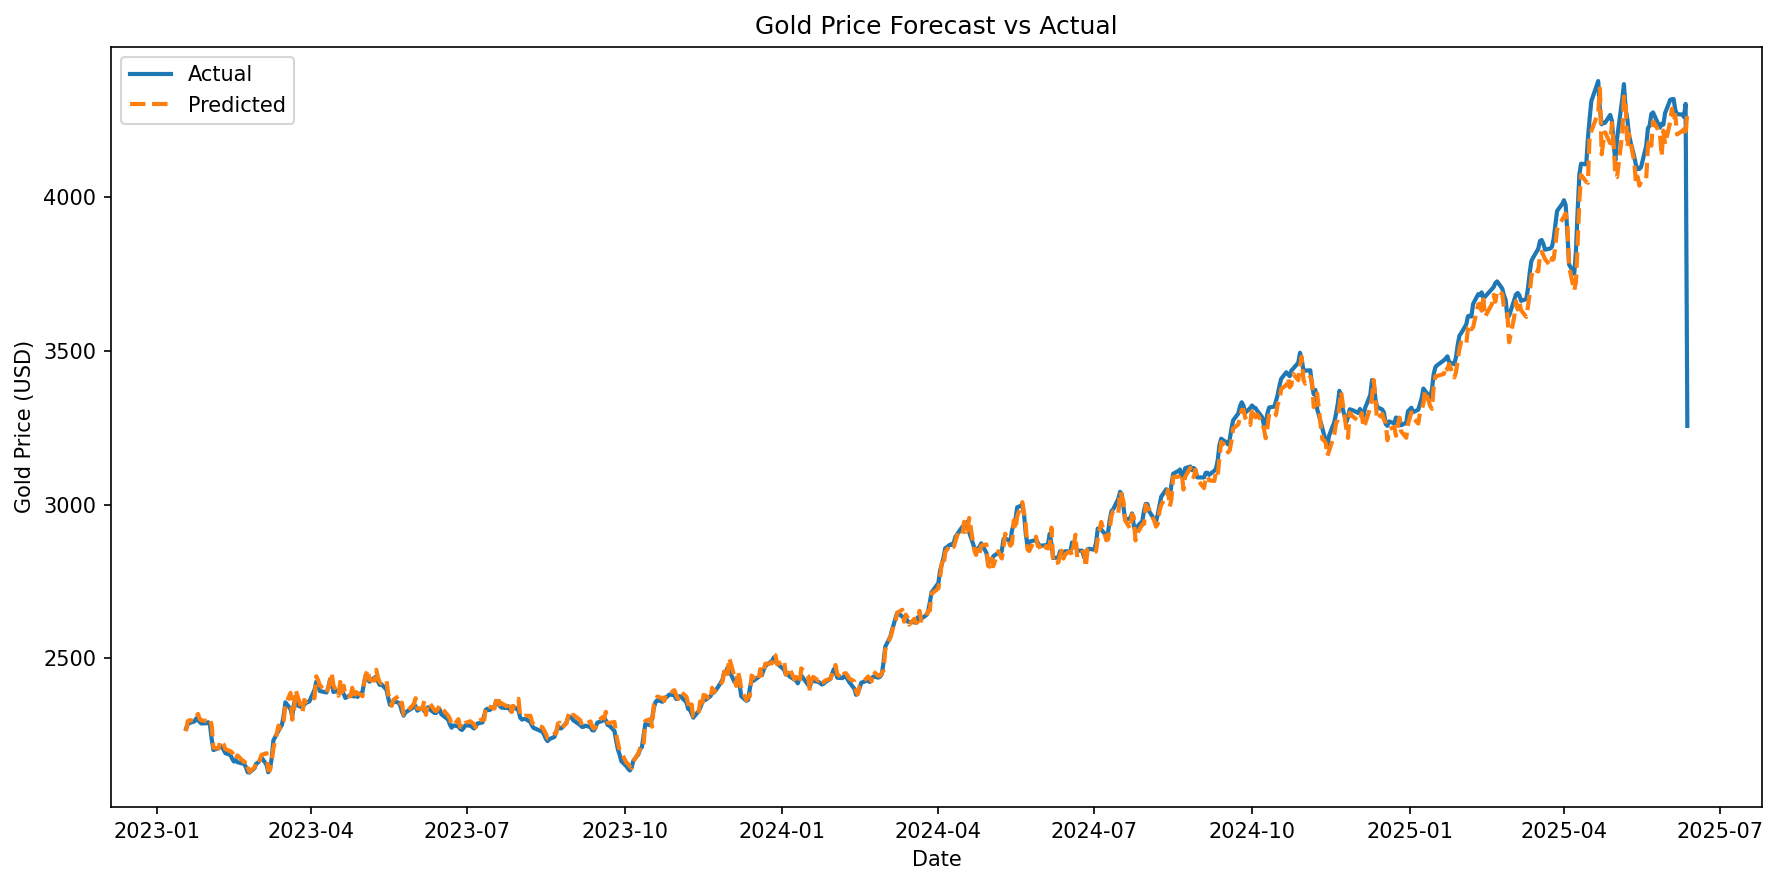

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error


y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
dates = test_df.index[look_back:]
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
print(f"Test MAPE: {mape:.2f}%")


plt.figure(figsize=(12,6), dpi=150)
plt.plot(dates, y_true, label='Actual', linewidth=2)
plt.plot(dates, y_pred, label='Predicted', linestyle='--', linewidth=2)
plt.title("Gold Price Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np


y_true = true_prices.flatten()
y_pred = combo_prices.flatten()


rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
r2   = r2_score(y_true, y_pred)

n   = len(y_true)
sse = np.sum((y_true - y_pred)**2)
rse = np.sqrt(sse / (n - 1 - 1))

print(f"RMSE: {rmse:.2f} USD")
print(f"MAE:  {mae:.2f} USD")
print(f"MAPE: {mape:.2f}%")
print(f"RSE:  {rse:.2f} USD")
print(f"R²:   {r2:.4f}")


RMSE: 52.20 USD
MAE:  24.27 USD
MAPE: 0.78%
RSE:  52.29 USD
R²:   0.9927


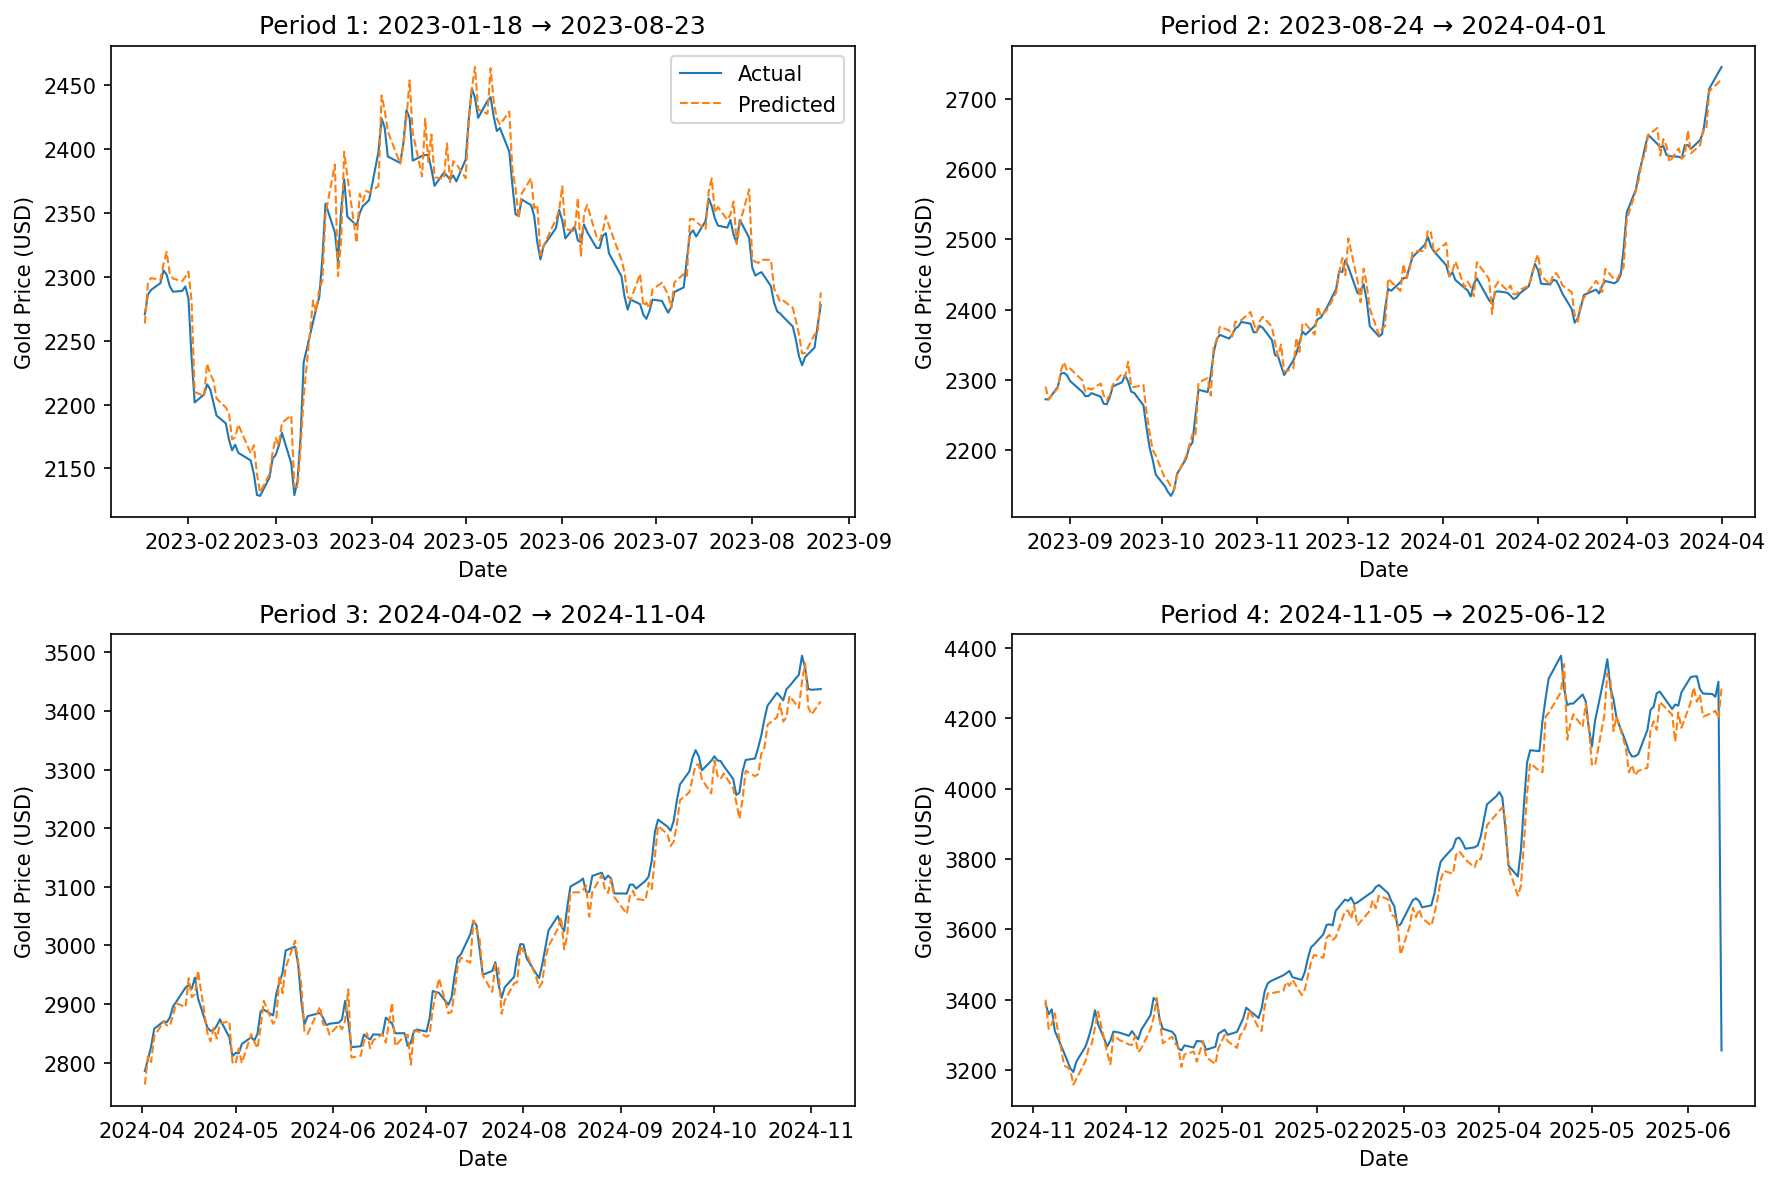

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
dates  = test_df.index[look_back:]


n_plots   = 4
N         = len(dates)
chunk     = N // n_plots


fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=150)
axes     = axes.flatten()

for i, ax in enumerate(axes):
    start = i * chunk
    end   = (i + 1) * chunk if i < n_plots - 1 else N

    ax.plot(dates[start:end], y_true[start:end], label='Actual', linewidth=1)
    ax.plot(dates[start:end], y_pred[start:end], label='Predicted',
            linestyle='--', linewidth=1)

    ax.set_title(f'Period {i+1}: {dates[start].date()} → {dates[end-1].date()}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Gold Price (USD)')
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()


#lookback = 5, wavelet = db1, level = 1

In [ ]:
import numpy as np
import pandas as pd
import pywt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


import yfinance as yf
start_date = "2010-01-01"
end_date   = pd.Timestamp.today().strftime("%Y-%m-%d")
df = yf.download("GC=F", start=start_date, end=end_date)[["Close"]].dropna()


train_val_df = df.loc[:'2023-01-01']
test_df      = df.loc['2023-01-02':]


val_size   = int(0.15 * len(train_val_df))
train_df   = train_val_df.iloc[:-val_size]
val_df     = train_val_df.iloc[-val_size:]
print(f"Rows → Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


scaler      = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train_df[['Close']])
val_scaled   = scaler.transform(val_df[['Close']])
test_scaled  = scaler.transform(test_df[['Close']])


if train_scaled.shape[0] % 2 != 0:
    train_scaled = train_scaled[:-1]
    train_df = train_df.iloc[:-1]
if val_scaled.shape[0] % 2 != 0:
    val_scaled = val_scaled[:-1]
    val_df = val_df.iloc[:-1]
if test_scaled.shape[0] % 2 != 0:
    test_scaled = test_scaled[:-1]
    test_df = test_df.iloc[:-1]


cA_train, cD_train = pywt.swt(train_scaled[:,0], 'db1', level=1)[0]
cA_val,   cD_val   = pywt.swt(val_scaled[:,0],   'db1', level=1)[0]
cA_test,  cD_test  = pywt.swt(test_scaled[:,0],  'db1', level=1)[0]


def make_sequences(data, look_back=5):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

look_back = 5
X_A_train, y_A_train = make_sequences(cA_train.reshape(-1,1), look_back)
X_A_val,   y_A_val   = make_sequences(cA_val.reshape(-1,1),   look_back)
X_A_test,  y_A_test  = make_sequences(cA_test.reshape(-1,1),  look_back)

X_D_train, y_D_train = make_sequences(cD_train.reshape(-1,1), look_back)
X_D_val,   y_D_val   = make_sequences(cD_val.reshape(-1,1),   look_back)
X_D_test,  y_D_test  = make_sequences(cD_test.reshape(-1,1),  look_back)

X_A_train = X_A_train.reshape(-1, look_back, 1)
X_A_val   = X_A_val.reshape(-1, look_back, 1)
X_A_test  = X_A_test.reshape(-1, look_back, 1)
X_D_train = X_D_train.reshape(-1, look_back, 1)
X_D_val   = X_D_val.reshape(-1, look_back, 1)
X_D_test  = X_D_test.reshape(-1, look_back, 1)

def build_lstm_model():
    m = Sequential([
        LSTM(100, input_shape=(look_back, 1)),
        Dense(1)
    ])
    m.compile(optimizer='adam', loss='mean_absolute_percentage_error')
    return m

model_A = build_lstm_model()
model_D = build_lstm_model()


history_A = model_A.fit(
    X_A_train, y_A_train,
    epochs=150, batch_size=100,
    shuffle=False,
    validation_data=(X_A_val, y_A_val),
    verbose=2
)
history_D = model_D.fit(
    X_D_train, y_D_train,
    epochs=150, batch_size=100,
    shuffle=False,
    validation_data=(X_D_val, y_D_val),
    verbose=2
)


pred_A = model_A.predict(X_A_test).flatten()
pred_D = model_D.predict(X_D_test).flatten()
combo_scaled = pred_A + pred_D


combo_prices = scaler.inverse_transform(combo_scaled.reshape(-1,1))
true_prices  = scaler.inverse_transform(y_A_test.reshape(-1,1))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Rows → Train: 2779, Val: 490, Test: 615
Epoch 1/150
28/28 - 8s - 285ms/step - loss: 40.0459 - val_loss: 2.5508
Epoch 2/150
28/28 - 0s - 13ms/step - loss: 11.8566 - val_loss: 10.5868
Epoch 3/150
28/28 - 0s - 16ms/step - loss: 8.7983 - val_loss: 5.0806
Epoch 4/150
28/28 - 0s - 13ms/step - loss: 7.9354 - val_loss: 3.0522
Epoch 5/150
28/28 - 0s - 14ms/step - loss: 7.5185 - val_loss: 2.3891
Epoch 6/150
28/28 - 0s - 14ms/step - loss: 7.2240 - val_loss: 2.4608
Epoch 7/150
28/28 - 1s - 22ms/step - loss: 7.2988 - val_loss: 2.6847
Epoch 8/150
28/28 - 1s - 36ms/step - loss: 7.4089 - val_loss: 2.6788
Epoch 9/150
28/28 - 0s - 14ms/step - loss: 7.0505 - val_loss: 2.3932
Epoch 10/150
28/28 - 1s - 24ms/step - loss: 6.8699 - val_loss: 2.6478
Epoch 11/150
28/28 - 0s - 13ms/step - loss: 7.6829 - val_loss: 2.5823
Epoch 12/150
28/28 - 0s - 17ms/step - loss: 7.3945 - val_loss: 2.3367
Epoch 13/150
28/28 - 0s - 16ms/step - loss: 6.9477 - val_loss: 2.2378
Epoch 14/150
28/28 - 1s - 33ms/step - loss: 6.7576 - va

Test MAPE: 0.76%


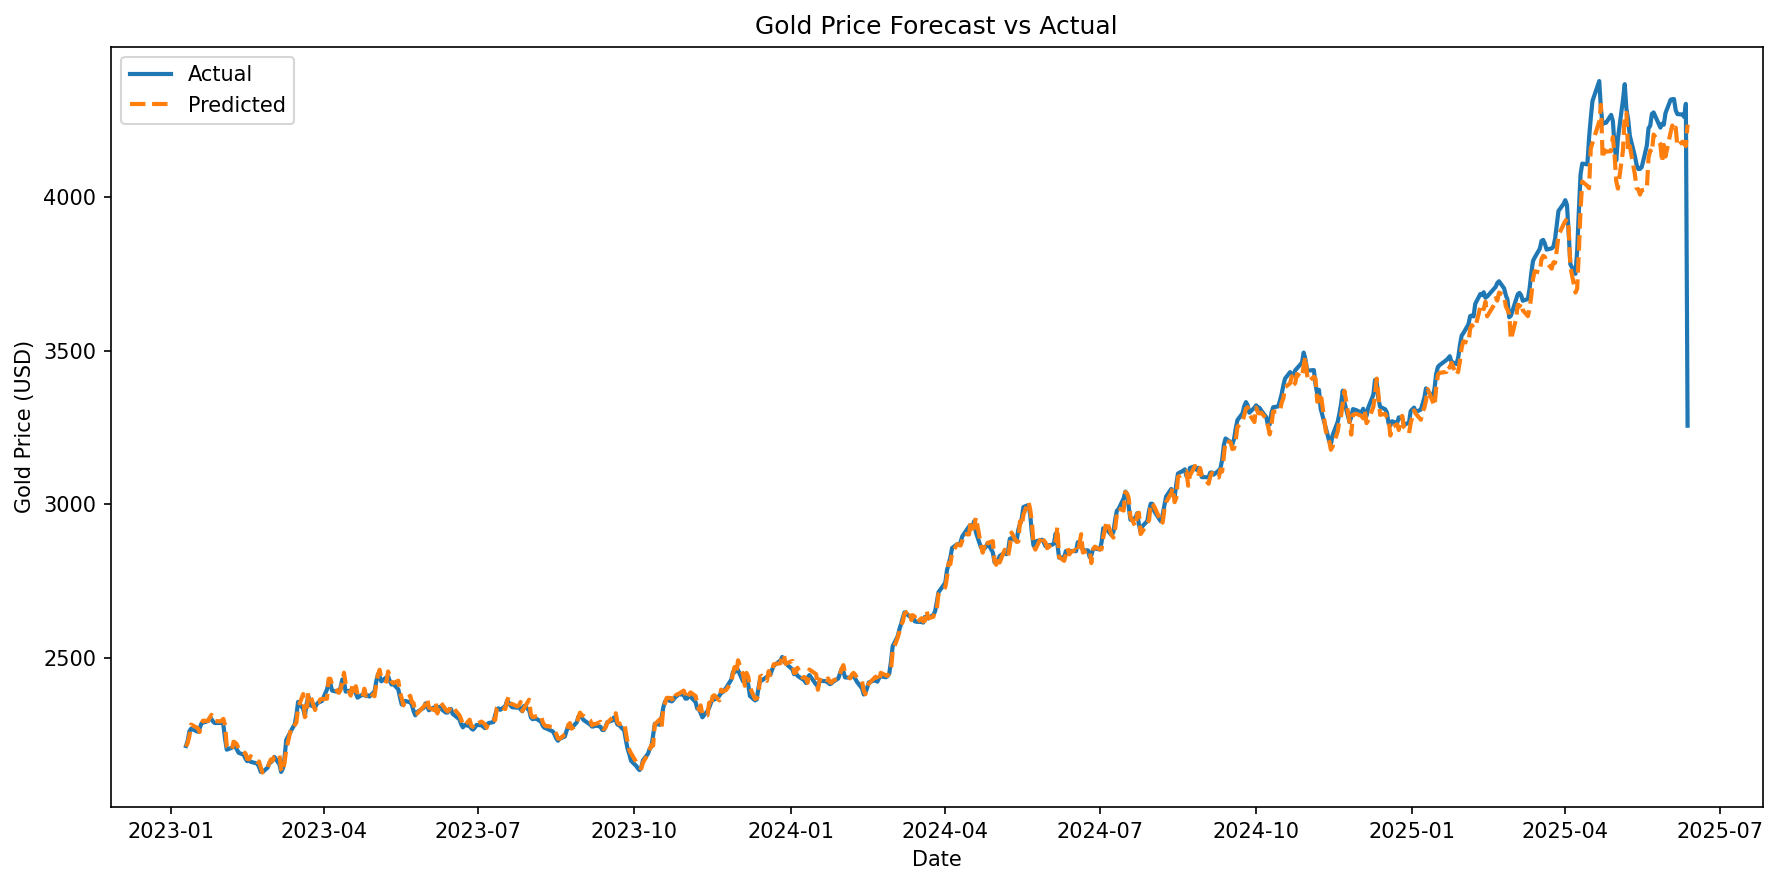

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error


y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
dates = test_df.index[look_back:]
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
print(f"Test MAPE: {mape:.2f}%")

plt.figure(figsize=(12,6), dpi=150)
plt.plot(dates, y_true, label='Actual', linewidth=2)
plt.plot(dates, y_pred, label='Predicted', linestyle='--', linewidth=2)
plt.title("Gold Price Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np


y_true = true_prices.flatten()
y_pred = combo_prices.flatten()

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
r2   = r2_score(y_true, y_pred)

n   = len(y_true)
sse = np.sum((y_true - y_pred)**2)
rse = np.sqrt(sse / (n - 1 - 1))

print(f"RMSE: {rmse:.2f} USD")
print(f"MAE:  {mae:.2f} USD")
print(f"MAPE: {mape:.2f}%")
print(f"RSE:  {rse:.2f} USD")
print(f"R²:   {r2:.4f}")


RMSE: 53.29 USD
MAE:  24.55 USD
MAPE: 0.76%
RSE:  53.38 USD
R²:   0.9924


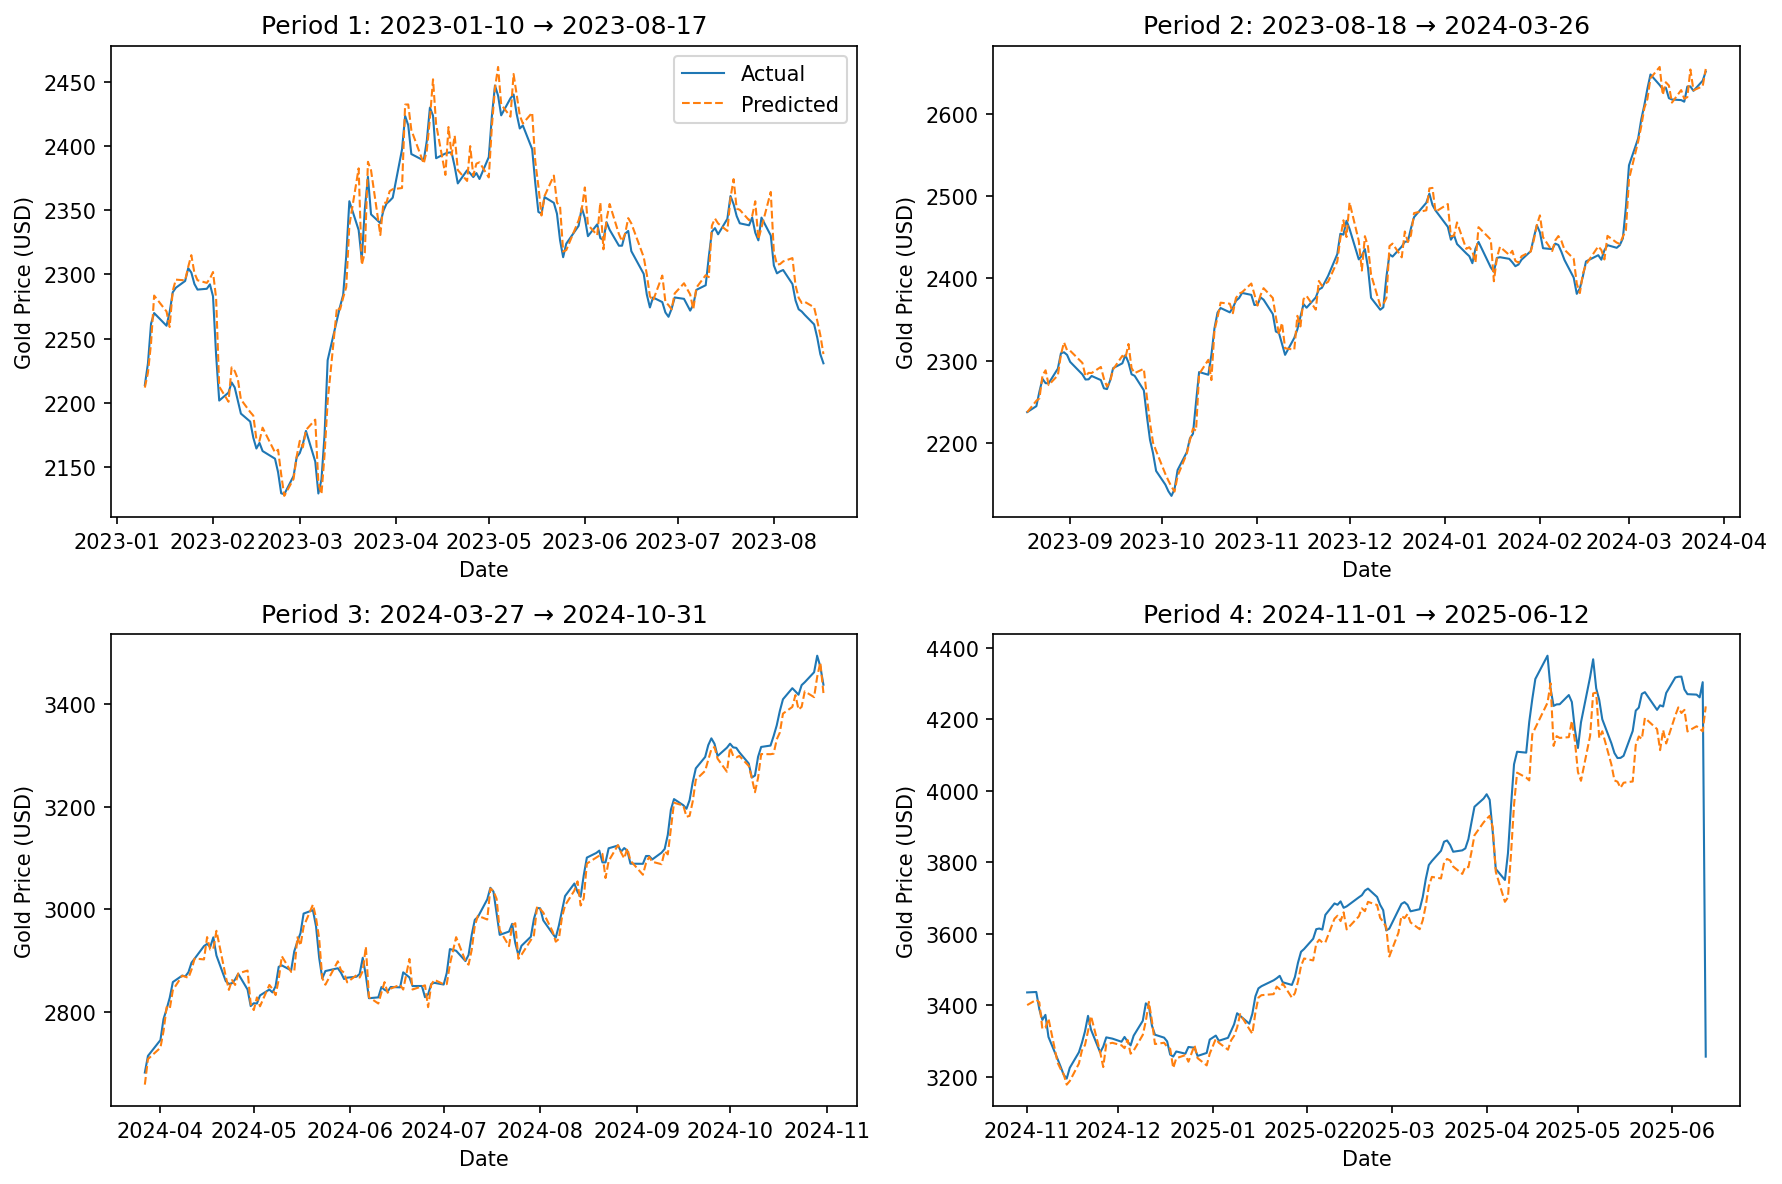

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
dates  = test_df.index[look_back:]

n_plots   = 4
N         = len(dates)
chunk     = N // n_plots

fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=150)
axes     = axes.flatten()

for i, ax in enumerate(axes):
    start = i * chunk
    end   = (i + 1) * chunk if i < n_plots - 1 else N

    ax.plot(dates[start:end], y_true[start:end], label='Actual', linewidth=1)
    ax.plot(dates[start:end], y_pred[start:end], label='Predicted',
            linestyle='--', linewidth=1)

    ax.set_title(f'Period {i+1}: {dates[start].date()} → {dates[end-1].date()}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Gold Price (USD)')
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()


#lookback = 50, wavelet = db1, level = 1

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas as pd
import pywt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


import yfinance as yf
start_date = "2010-01-01"
end_date   = pd.Timestamp.today().strftime("%Y-%m-%d")
df = yf.download("GC=F", start=start_date, end=end_date)[["Close"]].dropna()


train_val_df = df.loc[:'2023-01-01']
test_df      = df.loc['2023-01-02':]


val_size   = int(0.15 * len(train_val_df))
train_df   = train_val_df.iloc[:-val_size]
val_df     = train_val_df.iloc[-val_size:]

print(f"Rows → Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


scaler      = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train_df[['Close']])
val_scaled   = scaler.transform(val_df[['Close']])
test_scaled  = scaler.transform(test_df[['Close']])


if train_scaled.shape[0] % 2 != 0:
    train_scaled = train_scaled[:-1]
    train_df = train_df.iloc[:-1]
if val_scaled.shape[0] % 2 != 0:
    val_scaled = val_scaled[:-1]
    val_df = val_df.iloc[:-1]
if test_scaled.shape[0] % 2 != 0:
    test_scaled = test_scaled[:-1]
    test_df = test_df.iloc[:-1]



cA_train, cD_train = pywt.swt(train_scaled[:,0], 'db1', level=1)[0]
cA_val,   cD_val   = pywt.swt(val_scaled[:,0],   'db1', level=1)[0]
cA_test,  cD_test  = pywt.swt(test_scaled[:,0],  'db1', level=1)[0]


def make_sequences(data, look_back=50):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

look_back = 50
X_A_train, y_A_train = make_sequences(cA_train.reshape(-1,1), look_back)
X_A_val,   y_A_val   = make_sequences(cA_val.reshape(-1,1),   look_back)
X_A_test,  y_A_test  = make_sequences(cA_test.reshape(-1,1),  look_back)

X_D_train, y_D_train = make_sequences(cD_train.reshape(-1,1), look_back)
X_D_val,   y_D_val   = make_sequences(cD_val.reshape(-1,1),   look_back)
X_D_test,  y_D_test  = make_sequences(cD_test.reshape(-1,1),  look_back)


X_A_train = X_A_train.reshape(-1, look_back, 1)
X_A_val   = X_A_val.reshape(-1, look_back, 1)
X_A_test  = X_A_test.reshape(-1, look_back, 1)
X_D_train = X_D_train.reshape(-1, look_back, 1)
X_D_val   = X_D_val.reshape(-1, look_back, 1)
X_D_test  = X_D_test.reshape(-1, look_back, 1)


def build_lstm_model():
    m = Sequential([
        LSTM(100, input_shape=(look_back, 1)),
        Dense(1)
    ])
    m.compile(optimizer='adam', loss='mean_absolute_percentage_error')
    return m

model_A = build_lstm_model()
model_D = build_lstm_model()


history_A = model_A.fit(
    X_A_train, y_A_train,
    epochs=150, batch_size=100,
    shuffle=False,
    validation_data=(X_A_val, y_A_val),
    verbose=2
)
history_D = model_D.fit(
    X_D_train, y_D_train,
    epochs=150, batch_size=100,
    shuffle=False,
    validation_data=(X_D_val, y_D_val),
    verbose=2
)


pred_A = model_A.predict(X_A_test).flatten()
pred_D = model_D.predict(X_D_test).flatten()
combo_scaled = pred_A + pred_D
combo_prices = scaler.inverse_transform(combo_scaled.reshape(-1,1))
true_prices  = scaler.inverse_transform(y_A_test.reshape(-1,1))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Rows → Train: 2779, Val: 490, Test: 615
Epoch 1/150
28/28 - 3s - 102ms/step - loss: 40.9087 - val_loss: 33.8307
Epoch 2/150
28/28 - 2s - 81ms/step - loss: 25.7338 - val_loss: 17.4935
Epoch 3/150
28/28 - 1s - 53ms/step - loss: 17.2102 - val_loss: 5.5483
Epoch 4/150
28/28 - 3s - 107ms/step - loss: 12.5230 - val_loss: 3.4419
Epoch 5/150
28/28 - 2s - 69ms/step - loss: 10.7058 - val_loss: 6.0417
Epoch 6/150
28/28 - 1s - 47ms/step - loss: 11.4543 - val_loss: 3.9576
Epoch 7/150
28/28 - 1s - 45ms/step - loss: 12.0002 - val_loss: 2.7276
Epoch 8/150
28/28 - 1s - 48ms/step - loss: 13.5210 - val_loss: 7.5984
Epoch 9/150
28/28 - 2s - 88ms/step - loss: 10.2553 - val_loss: 2.6322
Epoch 10/150
28/28 - 1s - 47ms/step - loss: 9.9343 - val_loss: 2.5692
Epoch 11/150
28/28 - 2s - 68ms/step - loss: 14.1391 - val_loss: 10.5071
Epoch 12/150
28/28 - 2s - 71ms/step - loss: 11.2136 - val_loss: 3.1026
Epoch 13/150
28/28 - 3s - 90ms/step - loss: 7.7975 - val_loss: 2.9454
Epoch 14/150
28/28 - 3s - 92ms/step - loss:

Test MAPE: 21.43%


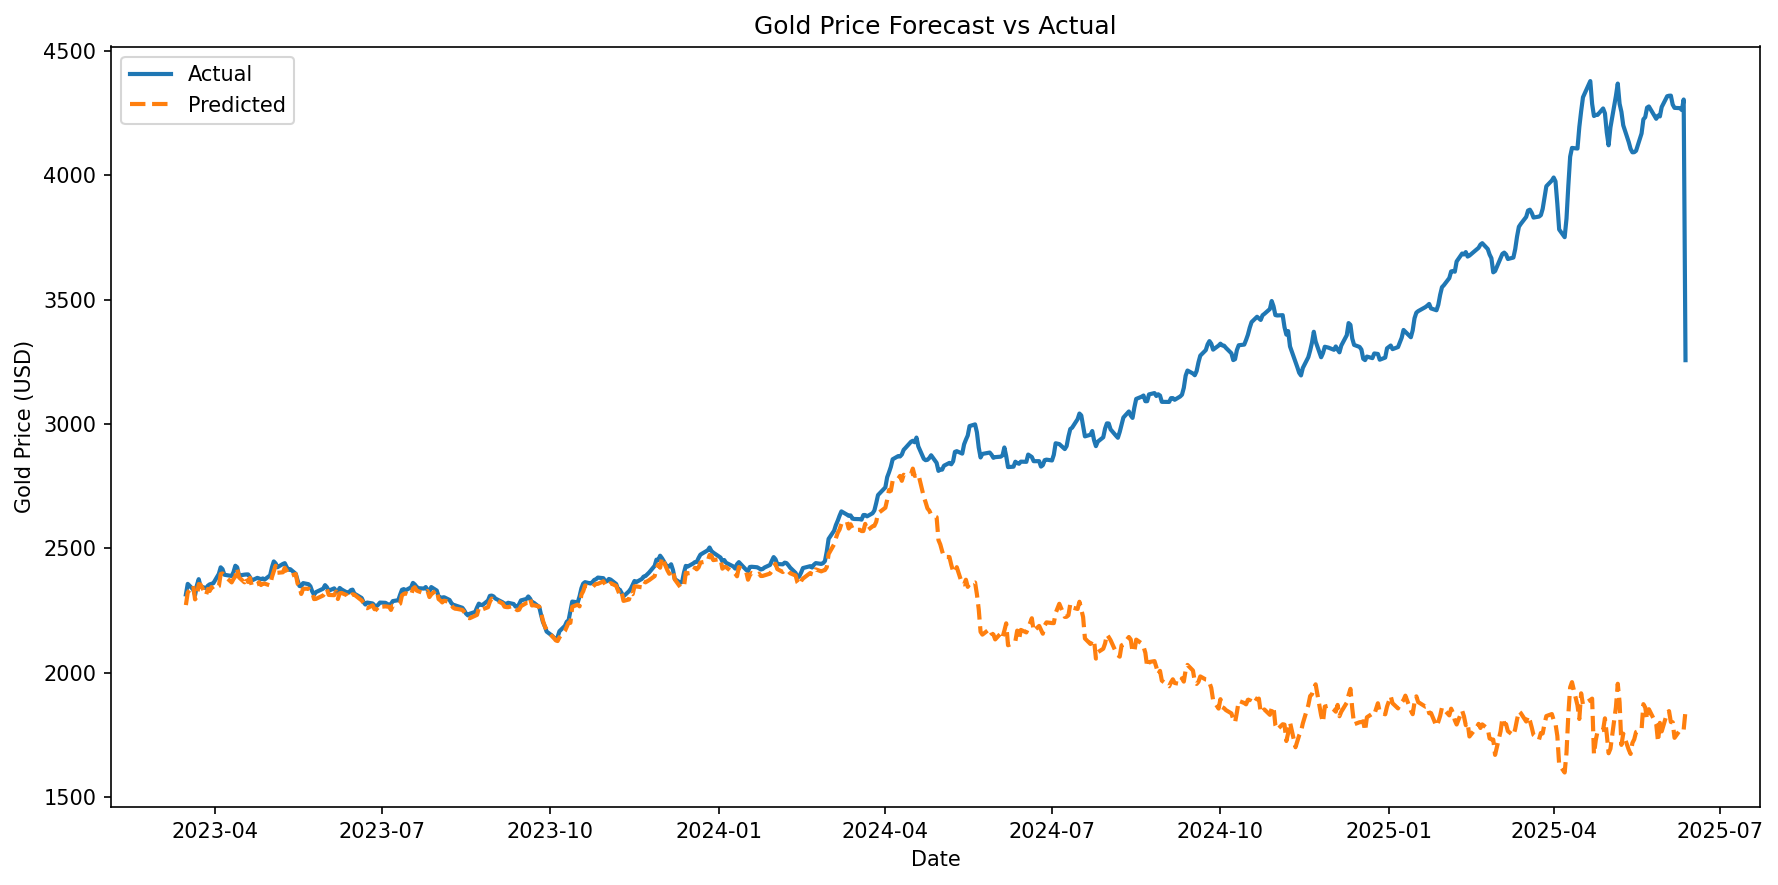

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error


y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
dates = test_df.index[look_back:]
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
print(f"Test MAPE: {mape:.2f}%")

plt.figure(figsize=(12,6), dpi=150)
plt.plot(dates, y_true, label='Actual', linewidth=2)
plt.plot(dates, y_pred, label='Predicted', linestyle='--', linewidth=2)
plt.title("Gold Price Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

RMSE: 1127.15 USD
MAE:  752.65 USD
MAPE: 21.43%
RSE:  1129.15 USD
R²:   -2.4618


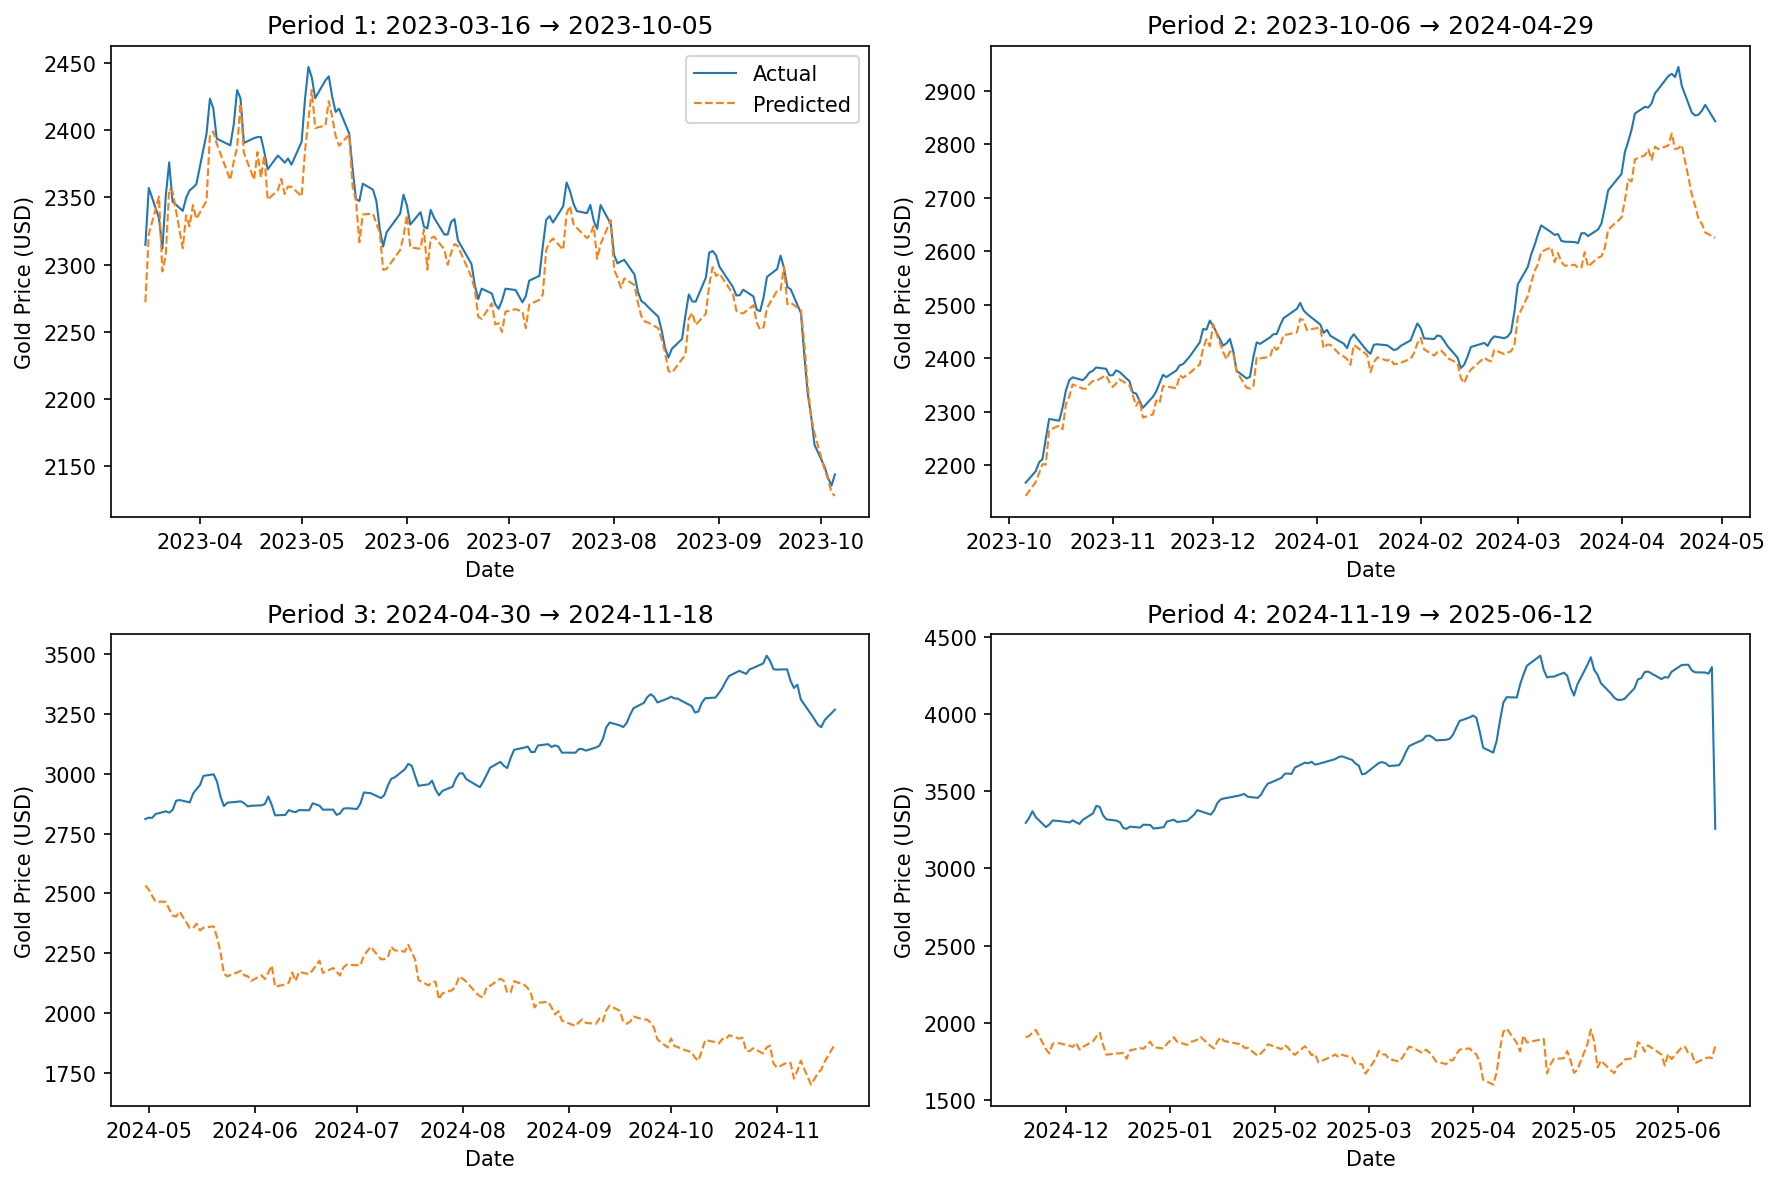

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

y_true = true_prices.flatten()
y_pred = combo_prices.flatten()


rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
r2   = r2_score(y_true, y_pred)

n   = len(y_true)
sse = np.sum((y_true - y_pred)**2)
rse = np.sqrt(sse / (n - 1 - 1))

print(f"RMSE: {rmse:.2f} USD")
print(f"MAE:  {mae:.2f} USD")
print(f"MAPE: {mape:.2f}%")
print(f"RSE:  {rse:.2f} USD")
print(f"R²:   {r2:.4f}")

y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
dates  = test_df.index[look_back:]

n_plots   = 4
N         = len(dates)
chunk     = N // n_plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=150)
axes     = axes.flatten()
for i, ax in enumerate(axes):
    start = i * chunk
    end   = (i + 1) * chunk if i < n_plots - 1 else N

    ax.plot(dates[start:end], y_true[start:end], label='Actual', linewidth=1)
    ax.plot(dates[start:end], y_pred[start:end], label='Predicted',
            linestyle='--', linewidth=1)

    ax.set_title(f'Period {i+1}: {dates[start].date()} → {dates[end-1].date()}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Gold Price (USD)')
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

#lookback = 1 , wavelet = db4, level = 2

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas as pd
import pywt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


import yfinance as yf
start_date = "2010-01-01"
end_date   = pd.Timestamp.today().strftime("%Y-%m-%d")
df = yf.download("GC=F", start=start_date, end=end_date)[["Close"]].dropna()


train_val_df = df.loc[:'2023-01-01']
test_df      = df.loc['2023-01-02':]


val_size   = int(0.15 * len(train_val_df))
train_df   = train_val_df.iloc[:-val_size]
val_df     = train_val_df.iloc[-val_size:]

print(f"Rows → Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


scaler      = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train_df[['Close']])
val_scaled   = scaler.transform(val_df[['Close']])
test_scaled  = scaler.transform(test_df[['Close']])


if train_scaled.shape[0] % 2 != 0:
    train_scaled = train_scaled[:-1]
    train_df = train_df.iloc[:-1]
if val_scaled.shape[0] % 2 != 0:
    val_scaled = val_scaled[:-1]
    val_df = val_df.iloc[:-1]
if test_scaled.shape[0] % 2 != 0:
    test_scaled = test_scaled[:-1]
    test_df = test_df.iloc[:-1]



wavelet = 'db4'
level   = 2

div = 2**level

def trim_for_swt(arr, df_ref):
    """Trim the last few samples so len(arr) % div == 0."""
    rem = arr.shape[0] % div
    if rem:
        arr = arr[:-rem]

        df_ref.drop(df_ref.tail(rem).index, inplace=True)
    return arr


train_scaled = trim_for_swt(train_scaled, train_df)
val_scaled   = trim_for_swt(val_scaled,   val_df)
test_scaled  = trim_for_swt(test_scaled,  test_df)

print("Trimmed lengths →",
      len(train_scaled), len(val_scaled), len(test_scaled))


coeffs_train = pywt.swt(train_scaled[:,0], wavelet, level=level)
coeffs_val   = pywt.swt(val_scaled[:,0],   wavelet, level=level)
coeffs_test  = pywt.swt(test_scaled[:,0],  wavelet, level=level)

cA_train = coeffs_train[-1][0]
cA_val   = coeffs_val[-1][0]
cA_test  = coeffs_test[-1][0]

cD_train = coeffs_train[0][1] + coeffs_train[1][1]
cD_val   = coeffs_val[0][1]   + coeffs_val[1][1]
cD_test  = coeffs_test[0][1]  + coeffs_test[1][1]



def make_sequences(data, look_back=1):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

look_back = 1
X_A_train, y_A_train = make_sequences(cA_train.reshape(-1,1), look_back)
X_A_val,   y_A_val   = make_sequences(cA_val.reshape(-1,1),   look_back)
X_A_test,  y_A_test  = make_sequences(cA_test.reshape(-1,1),  look_back)

X_D_train, y_D_train = make_sequences(cD_train.reshape(-1,1), look_back)
X_D_val,   y_D_val   = make_sequences(cD_val.reshape(-1,1),   look_back)
X_D_test,  y_D_test  = make_sequences(cD_test.reshape(-1,1),  look_back)

X_A_train = X_A_train.reshape(-1, look_back, 1)
X_A_val   = X_A_val.reshape(-1, look_back, 1)
X_A_test  = X_A_test.reshape(-1, look_back, 1)
X_D_train = X_D_train.reshape(-1, look_back, 1)
X_D_val   = X_D_val.reshape(-1, look_back, 1)
X_D_test  = X_D_test.reshape(-1, look_back, 1)


def build_lstm_model():
    m = Sequential([
        LSTM(100, input_shape=(look_back, 1)),
        Dense(1)
    ])
    m.compile(optimizer='adam', loss='mean_absolute_percentage_error')
    return m

model_A = build_lstm_model()
model_D = build_lstm_model()


history_A = model_A.fit(
    X_A_train, y_A_train,
    epochs=150, batch_size=100,
    shuffle=False,
    validation_data=(X_A_val, y_A_val),
    verbose=2
)
history_D = model_D.fit(
    X_D_train, y_D_train,
    epochs=150, batch_size=100,
    shuffle=False,
    validation_data=(X_D_val, y_D_val),
    verbose=2
)


pred_A = model_A.predict(X_A_test).flatten()
pred_D = model_D.predict(X_D_test).flatten()
combo_scaled = pred_A + pred_D
combo_prices = scaler.inverse_transform(combo_scaled.reshape(-1,1))
true_prices  = scaler.inverse_transform(y_A_test.reshape(-1,1))

[*********************100%***********************]  1 of 1 completed
<ipython-input-2-1870391716>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ref.drop(df_ref.tail(rem).index, inplace=True)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Rows → Train: 2779, Val: 490, Test: 615
Trimmed lengths → 2776 488 612
Epoch 1/150
28/28 - 3s - 114ms/step - loss: 81.2495 - val_loss: 76.9920
Epoch 2/150
28/28 - 1s - 29ms/step - loss: 52.2731 - val_loss: 54.9569
Epoch 3/150
28/28 - 0s - 18ms/step - loss: 42.1544 - val_loss: 42.6090
Epoch 4/150
28/28 - 0s - 15ms/step - loss: 36.6192 - val_loss: 34.7719
Epoch 5/150
28/28 - 0s - 9ms/step - loss: 30.4451 - val_loss: 26.3982
Epoch 6/150
28/28 - 0s - 7ms/step - loss: 23.9125 - val_loss: 17.0590
Epoch 7/150
28/28 - 0s - 9ms/step - loss: 16.8252 - val_loss: 6.8819
Epoch 8/150
28/28 - 1s - 19ms/step - loss: 9.9041 - val_loss: 2.9298
Epoch 9/150
28/28 - 0s - 16ms/step - loss: 5.5844 - val_loss: 8.0262
Epoch 10/150
28/28 - 1s - 29ms/step - loss: 5.5773 - val_loss: 7.7547
Epoch 11/150
28/28 - 1s - 24ms/step - loss: 5.6034 - val_loss: 6.9433
Epoch 12/150
28/28 - 0s - 9ms/step - loss: 5.5706 - val_loss: 6.5792
Epoch 13/150
28/28 - 0s - 11ms/step - loss: 5.4161 - val_loss: 6.2147
Epoch 14/150
28/28

Test MAPE: 2.66%


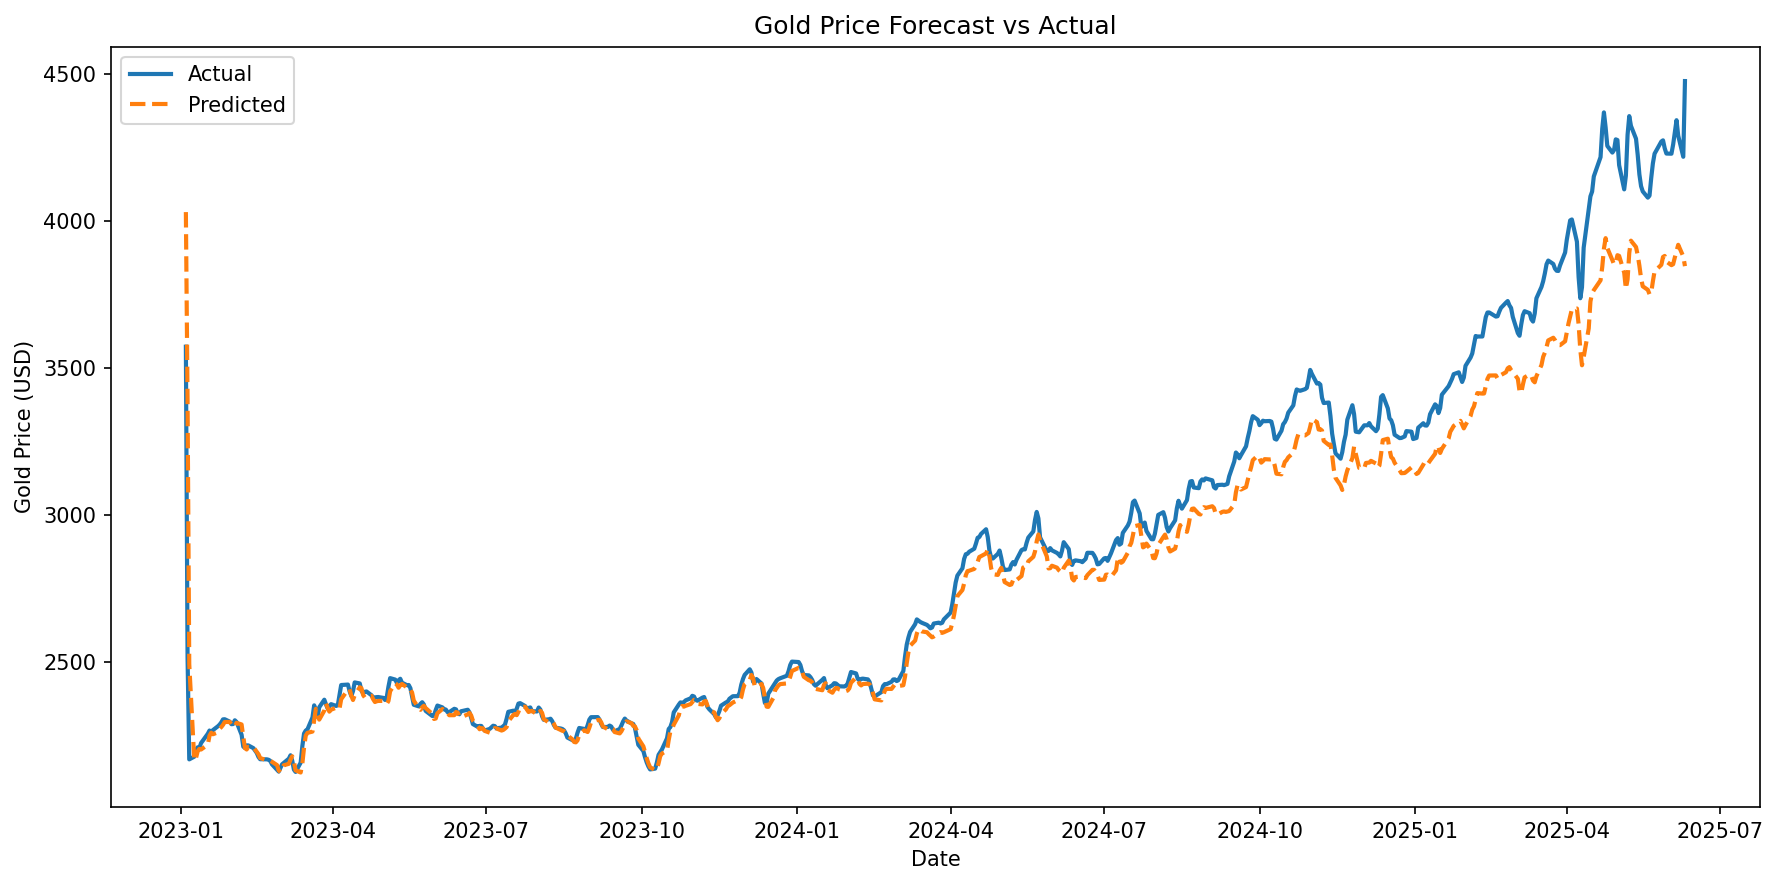

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error


y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
dates = test_df.index[look_back:]
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
print(f"Test MAPE: {mape:.2f}%")


plt.figure(figsize=(12,6), dpi=150)
plt.plot(dates, y_true, label='Actual', linewidth=2)
plt.plot(dates, y_pred, label='Predicted', linestyle='--', linewidth=2)
plt.title("Gold Price Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()


RMSE: 144.30 USD
MAE:  90.46 USD
MAPE: 2.66%
RSE:  144.54 USD
R²:   0.9430


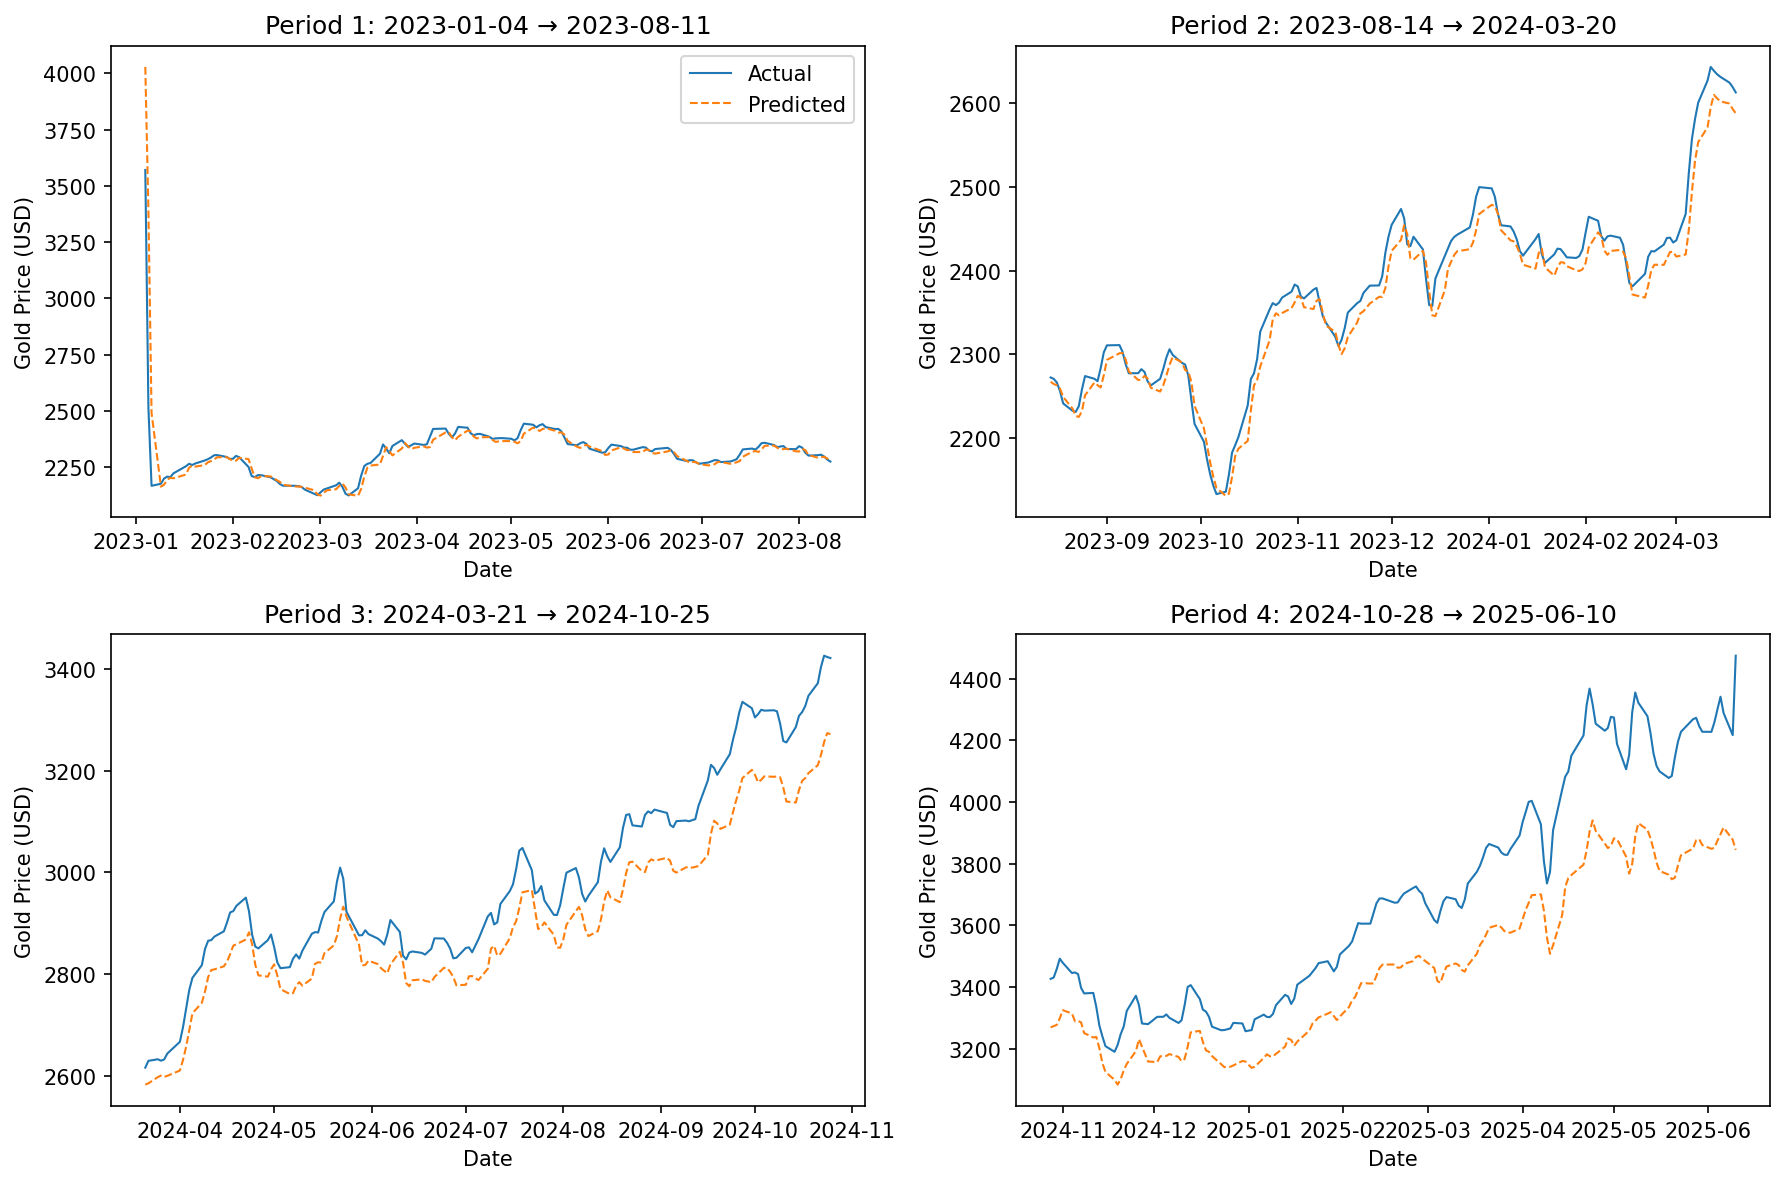

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
r2   = r2_score(y_true, y_pred)
n   = len(y_true)
sse = np.sum((y_true - y_pred)**2)
rse = np.sqrt(sse / (n - 1 - 1))

print(f"RMSE: {rmse:.2f} USD")
print(f"MAE:  {mae:.2f} USD")
print(f"MAPE: {mape:.2f}%")
print(f"RSE:  {rse:.2f} USD")
print(f"R²:   {r2:.4f}")


y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
dates  = test_df.index[look_back:]

n_plots   = 4
N         = len(dates)
chunk     = N // n_plots


fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=150)
axes     = axes.flatten()

for i, ax in enumerate(axes):
    start = i * chunk
    end   = (i + 1) * chunk if i < n_plots - 1 else N

    ax.plot(dates[start:end], y_true[start:end], label='Actual', linewidth=1)
    ax.plot(dates[start:end], y_pred[start:end], label='Predicted',
            linestyle='--', linewidth=1)

    ax.set_title(f'Period {i+1}: {dates[start].date()} → {dates[end-1].date()}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Gold Price (USD)')
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

#lookback = 1, wavelet = sym3, level = 2

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas as pd
import pywt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


import yfinance as yf
start_date = "2010-01-01"
end_date   = pd.Timestamp.today().strftime("%Y-%m-%d")
df = yf.download("GC=F", start=start_date, end=end_date)[["Close"]].dropna()


train_val_df = df.loc[:'2023-01-01']
test_df      = df.loc['2023-01-02':]


val_size   = int(0.15 * len(train_val_df))
train_df   = train_val_df.iloc[:-val_size]
val_df     = train_val_df.iloc[-val_size:]

print(f"Rows → Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


scaler      = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train_df[['Close']])
val_scaled   = scaler.transform(val_df[['Close']])
test_scaled  = scaler.transform(test_df[['Close']])

if train_scaled.shape[0] % 2 != 0:
    train_scaled = train_scaled[:-1]
    train_df = train_df.iloc[:-1]
if val_scaled.shape[0] % 2 != 0:
    val_scaled = val_scaled[:-1]
    val_df = val_df.iloc[:-1]
if test_scaled.shape[0] % 2 != 0:
    test_scaled = test_scaled[:-1]
    test_df = test_df.iloc[:-1]


wavelet = 'sym3'
level   = 2
div     = 2**level

def trim_for_swt(arr, df_ref):
    rem = arr.shape[0] % div
    if rem:
        arr = arr[:-rem]
        df_ref.drop(df_ref.tail(rem).index, inplace=True)
    return arr

train_scaled = trim_for_swt(train_scaled, train_df)
val_scaled   = trim_for_swt(val_scaled,   val_df)
test_scaled  = trim_for_swt(test_scaled,  test_df)


coeffs_train = pywt.swt(train_scaled[:,0], wavelet, level=level)
coeffs_val   = pywt.swt(val_scaled[:,0],   wavelet, level=level)
coeffs_test  = pywt.swt(test_scaled[:,0],  wavelet, level=level)


cA_train = coeffs_train[-1][0]
cA_val   = coeffs_val[-1][0]
cA_test  = coeffs_test[-1][0]

cD_train = coeffs_train[0][1] + coeffs_train[1][1]
cD_val   = coeffs_val[0][1]   + coeffs_val[1][1]
cD_test  = coeffs_test[0][1]  + coeffs_test[1][1]

print("Decomposed with Symlet-3 @ level 2 →",
      "cA_train:", cA_train.shape,
      "cD_train:", cD_train.shape)

def make_sequences(data, look_back=1):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

look_back = 1
X_A_train, y_A_train = make_sequences(cA_train.reshape(-1,1), look_back)
X_A_val,   y_A_val   = make_sequences(cA_val.reshape(-1,1),   look_back)
X_A_test,  y_A_test  = make_sequences(cA_test.reshape(-1,1),  look_back)

X_D_train, y_D_train = make_sequences(cD_train.reshape(-1,1), look_back)
X_D_val,   y_D_val   = make_sequences(cD_val.reshape(-1,1),   look_back)
X_D_test,  y_D_test  = make_sequences(cD_test.reshape(-1,1),  look_back)


X_A_train = X_A_train.reshape(-1, look_back, 1)
X_A_val   = X_A_val.reshape(-1, look_back, 1)
X_A_test  = X_A_test.reshape(-1, look_back, 1)
X_D_train = X_D_train.reshape(-1, look_back, 1)
X_D_val   = X_D_val.reshape(-1, look_back, 1)
X_D_test  = X_D_test.reshape(-1, look_back, 1)


def build_lstm_model():
    m = Sequential([
        LSTM(100, input_shape=(look_back, 1)),
        Dense(1)
    ])
    m.compile(optimizer='adam', loss='mean_absolute_percentage_error')
    return m

model_A = build_lstm_model()
model_D = build_lstm_model()


history_A = model_A.fit(
    X_A_train, y_A_train,
    epochs=150, batch_size=100,
    shuffle=False,
    validation_data=(X_A_val, y_A_val),
    verbose=2
)
history_D = model_D.fit(
    X_D_train, y_D_train,
    epochs=150, batch_size=100,
    shuffle=False,
    validation_data=(X_D_val, y_D_val),
    verbose=2
)


pred_A = model_A.predict(X_A_test).flatten()
pred_D = model_D.predict(X_D_test).flatten()
combo_scaled = pred_A + pred_D


combo_prices = scaler.inverse_transform(combo_scaled.reshape(-1,1))
true_prices  = scaler.inverse_transform(y_A_test.reshape(-1,1))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
<ipython-input-1-3161163464>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ref.drop(df_ref.tail(rem).index, inplace=True)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Rows → Train: 2779, Val: 490, Test: 615
Decomposed with Symlet-3 @ level 2 → cA_train: (2776,) cD_train: (2776,)
Epoch 1/150
28/28 - 3s - 112ms/step - loss: 82.8112 - val_loss: 78.9612
Epoch 2/150
28/28 - 0s - 8ms/step - loss: 54.6295 - val_loss: 57.4229
Epoch 3/150
28/28 - 0s - 15ms/step - loss: 43.0448 - val_loss: 43.9999
Epoch 4/150
28/28 - 0s - 17ms/step - loss: 37.7835 - val_loss: 36.0260
Epoch 5/150
28/28 - 0s - 14ms/step - loss: 31.8153 - val_loss: 28.0304
Epoch 6/150
28/28 - 0s - 16ms/step - loss: 25.4094 - val_loss: 18.9371
Epoch 7/150
28/28 - 0s - 16ms/step - loss: 18.4367 - val_loss: 8.9288
Epoch 8/150
28/28 - 0s - 8ms/step - loss: 11.1727 - val_loss: 1.7693
Epoch 9/150
28/28 - 0s - 8ms/step - loss: 6.0681 - val_loss: 7.4936
Epoch 10/150
28/28 - 0s - 9ms/step - loss: 5.5028 - val_loss: 7.7815
Epoch 11/150
28/28 - 0s - 13ms/step - loss: 5.5710 - val_loss: 6.9003
Epoch 12/150
28/28 - 0s - 8ms/step - loss: 5.5227 - val_loss: 6.3701
Epoch 13/150
28/28 - 0s - 12ms/step - loss: 5.

Test MAPE: 2.88%


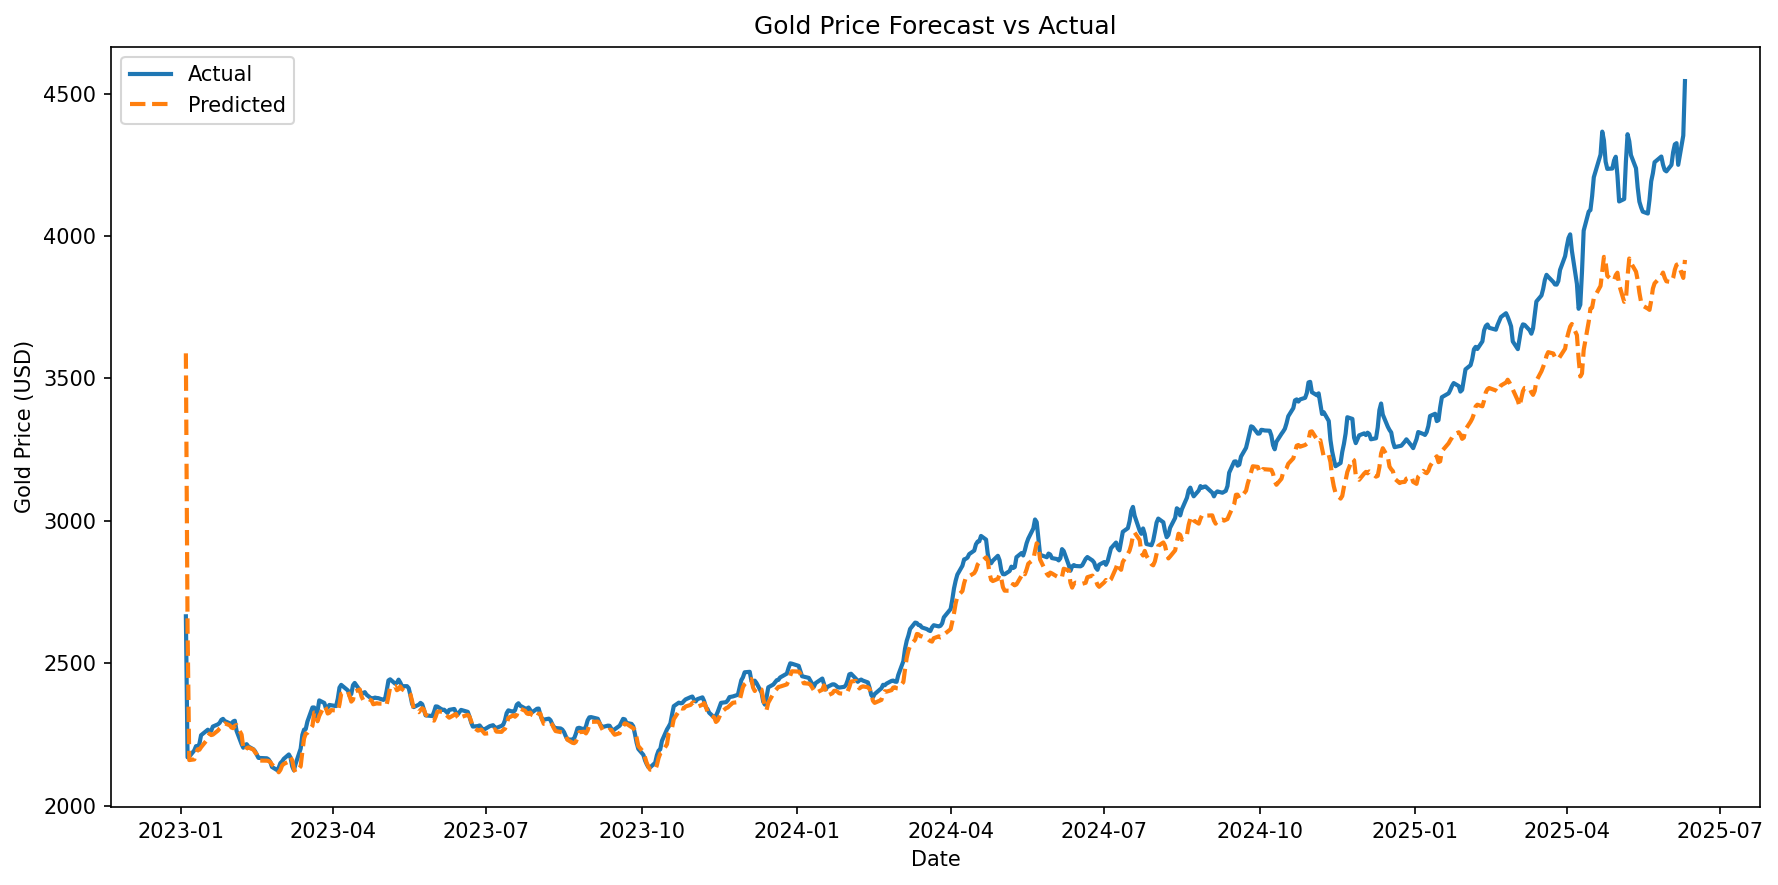

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error


y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
dates = test_df.index[look_back:]
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
print(f"Test MAPE: {mape:.2f}%")

plt.figure(figsize=(12,6), dpi=150)
plt.plot(dates, y_true, label='Actual', linewidth=2)
plt.plot(dates, y_pred, label='Predicted', linestyle='--', linewidth=2)
plt.title("Gold Price Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

RMSE: 150.48 USD
MAE:  96.78 USD
MAPE: 2.88%
RSE:  150.72 USD
R²:   0.9385


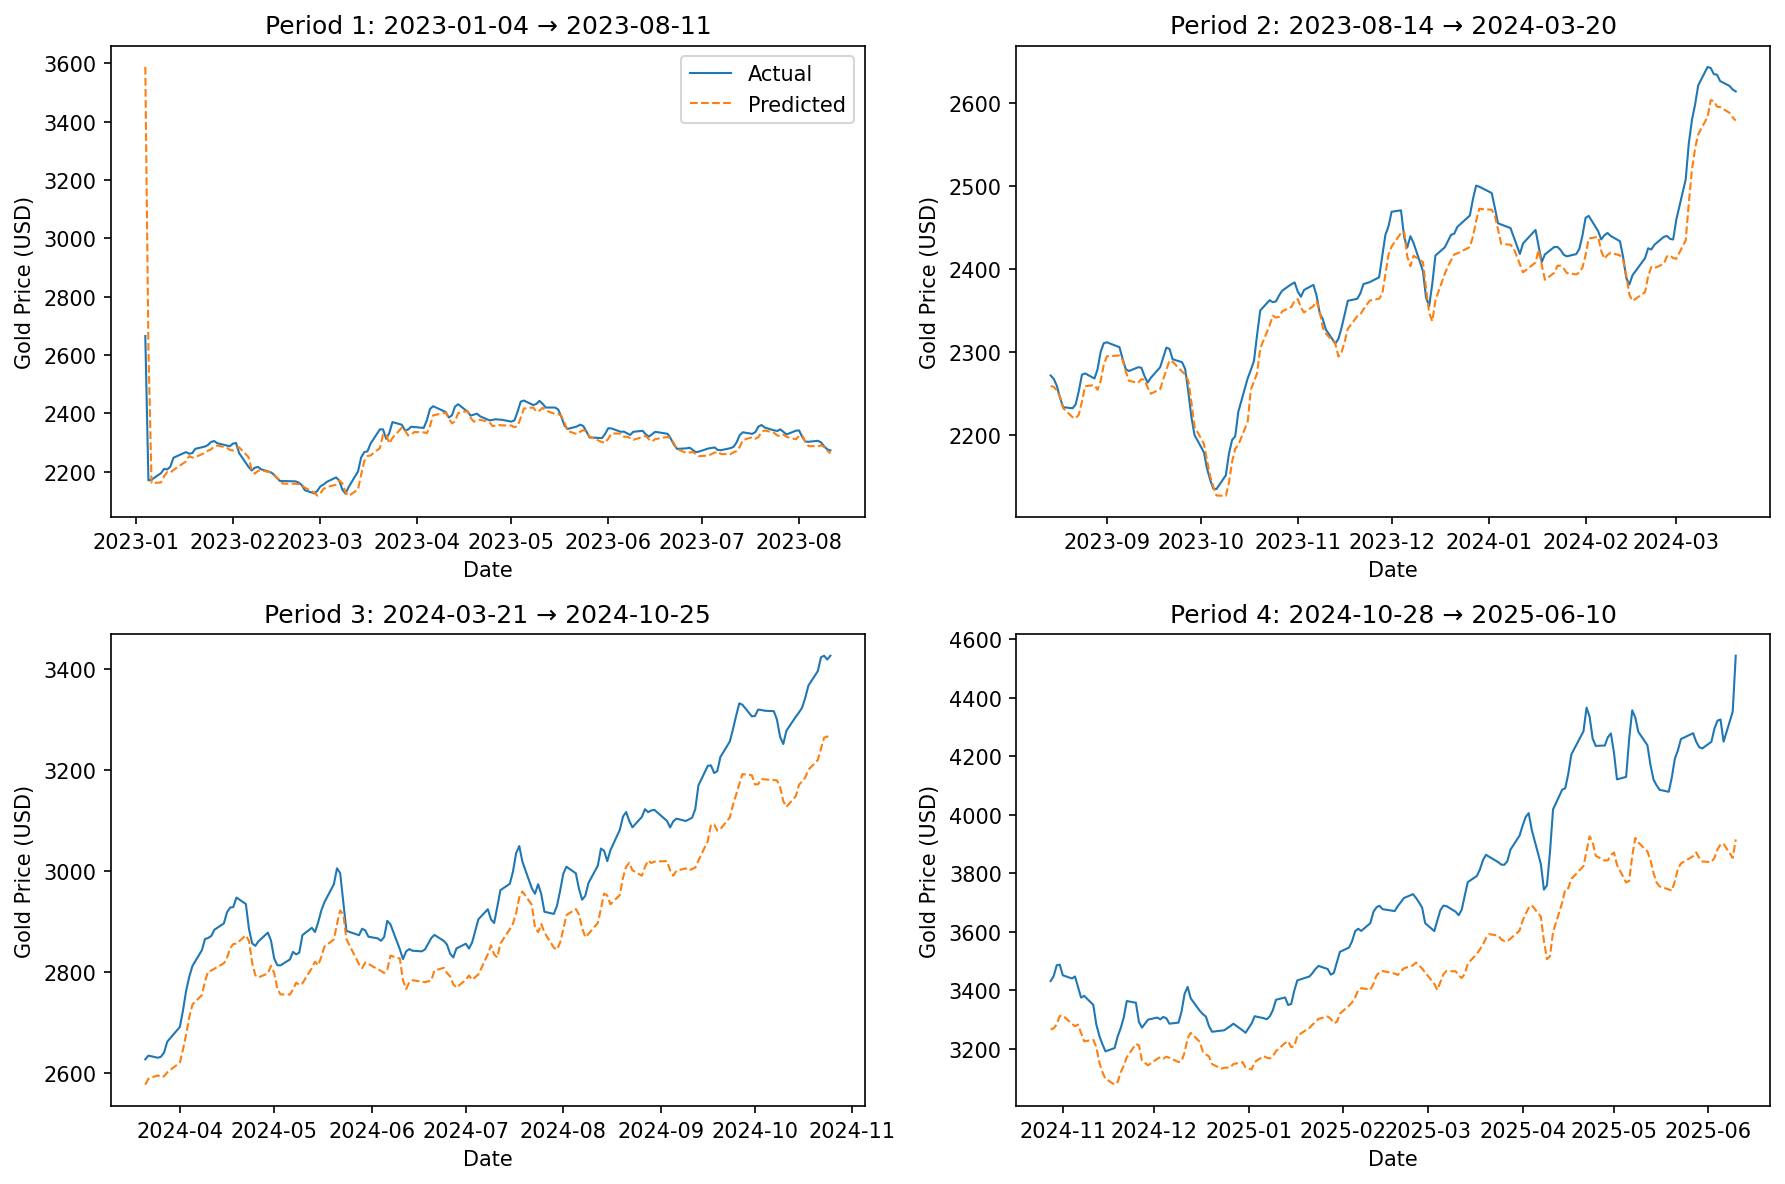

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

y_true = true_prices.flatten()
y_pred = combo_prices.flatten()

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
r2   = r2_score(y_true, y_pred)
n   = len(y_true)
sse = np.sum((y_true - y_pred)**2)
rse = np.sqrt(sse / (n - 1 - 1))

print(f"RMSE: {rmse:.2f} USD")
print(f"MAE:  {mae:.2f} USD")
print(f"MAPE: {mape:.2f}%")
print(f"RSE:  {rse:.2f} USD")
print(f"R²:   {r2:.4f}")

y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
dates  = test_df.index[look_back:]

n_plots   = 4
N         = len(dates)
chunk     = N // n_plots


fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=150)
axes     = axes.flatten()

for i, ax in enumerate(axes):
    start = i * chunk
    end   = (i + 1) * chunk if i < n_plots - 1 else N

    ax.plot(dates[start:end], y_true[start:end], label='Actual', linewidth=1)
    ax.plot(dates[start:end], y_pred[start:end], label='Predicted',
            linestyle='--', linewidth=1)

    ax.set_title(f'Period {i+1}: {dates[start].date()} → {dates[end-1].date()}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Gold Price (USD)')
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()